** Donor Quality **
* nUMI
* %MT 
* %Intronic
* nDAN
* nImmune?
* read depth

** Steps ** <br>
(1) Load raw donors <br>
(2) (IDIOSYNCRATIC TO THIS NOTEBOOK) add in participant_id <br>
(3) calculate the above <br>
    (a) As N <br>
    (b) As Frac Total Droplets <br>
    (c) As Frac of Clean Droplets

In [1]:
source("~/sc-online/getData.R")
source("~/sc-online/utils.R")
source("~/sc-online/plot.R")
library(qs)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats




Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeigh

In [2]:
calico_libs_long = readLines("~/calico-libs-all.txt")
calico_libs = lapply(calico_libs_long, function(x) {
    strsplit(x, split = "_")[[1]][[2]]
})
names(calico_libs_long) = calico_libs
BASE_PATH = "/mnt/accessory/seq_data/calico"

dapi_nurr = list(
    'nurr', 'dapi', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 'dapi',
    'nurr', 'nurr', 
    'dapi', 'dapi', 'nurr',
    'nurr', 'nurr', 'dapi',
    'dapi', 'dapi', 'dapi',
    'nurr', 'nurr', 'dapi')
names(dapi_nurr) = calico_libs

short_lib_names = list(
    '19B', '19BD', '19C', '19CD',
    '19D1', '19D2', '19DD',
    '19E1', '19E2', '19ED',
    '19F1', '19F2', '19FD',
    '19G1', '19G2', '19GD',
    '19I1', '19I2', '19ID',
    '19J1', '19J2', '19JD',
    '19K1', '19K2',
    '21A8', '21A9', 
    '21B8', '21B9',
    '21C8', '21C9', 
    '21D8', '21D9',
    '21E8', '21F8', '21G8', '21H8'   
)
names(short_lib_names) = calico_libs


In [3]:
# in this case, load all data
calico_sce_list = loadCbSceList(calico_libs,
    log10_nUMI_threshold_list=setNames(rep(0, length(calico_libs)), calico_libs),
    cb_sce_basename = "cb_data_sce_FPR_0.01.rds",
    filter_out_unclean = FALSE,
    filter_out_unassignable=FALSE,
    dapi_nurr = dapi_nurr,
    short_lib_names = short_lib_names
)

nurr_seurat_clean = qread("/mnt/accessory/seq_data/calico/seurat_nurr_merged_initial_harmonized_20240130.qs")

In [4]:
calico_all = .mycBindFn(calico_sce_list)


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand




[1] "batch information is in the anno_batch variable"


In [5]:
calico_all = calico_all[, !colData(calico_all)$donor_id %in% c("doublet", "unassigned")]

In [97]:
# add participant ID
manifest = read.table("~/Calico_Macosko_PD_GSA_Terra_Manifest_20240220.tsv", sep='\t',header=T,skip=0)
sort(colnames(manifest))

manifest$donor_id = sapply(manifest$entity.sample_id, function(x) gsub("_1$", "", x))
manifest$sex = manifest$Sex
manifest$age = manifest$Age 
manifest$participant_id = ifelse(
    is.null(manifest$CORRECT.donor), 
    manifest$collaborator_participant_id,
    manifest$CORRECT.donor
)
manifest$case_control = ifelse(manifest$Disease == 'Control', 'ctr', 'pd')
manifest = manifest[, c('donor_id', 'participant_id', 'case_control', 'sex', 'age')]

old_cd = as.data.frame(colData(calico_all))
old_cd$row_names_orig = rownames(old_cd)
new_cd = merge(old_cd, manifest, by="donor_id")
rownames(new_cd) = new_cd$row_names_orig
new_cd = new_cd[match(colnames(calico_all), rownames(new_cd)), ]
new_cd$row_names_orig = NULL

sum(rownames(new_cd) != colnames(calico_all))
colData(calico_all) = DataFrame(new_cd)

[1] "Age"                         "autocall_call_rate"         
 [3] "autocall_gender"             "autocall_version"           
 [5] "call_date"                   "call_rate"                  
 [7] "called_infinium_snps"        "chip"                       
 [9] "chip_well_barcode"           "collaborator_participant_id"
[11] "collaborator_sample_id"      "CORRECT.donor"              
[13] "Disease"                     "entity.sample_id"           
[15] "fp_gender"                   "fp_lod_score"               
[17] "gender_concordance"          "green_idat"                 
[19] "gtc"                         "hap_map_concordance"        
[21] "het_rate"                    "last_cluster_file"          
[23] "participant"                 "pdo"                        
[25] "red_idat"                    "release_date"               
[27] "reported_gender"             "reported_gender.1"          
[29] "research_project_id"         "scan_date"                  
[31] "Sex"                         "stock_sample"               
[33] "vcf"                         "vcf_index"                  
[35] "version"                     "zcall_version"

[1] 6

In [43]:
calico_nurr = calico_all[, colData(calico_all)$sort == 'nurr']
calico_dapi = calico_all[, colData(calico_all)$sort == 'dapi']
nurr_cd = as.data.frame(colData(calico_nurr))
dapi_cd = as.data.frame(colData(calico_dapi))

nurr_clean_md = nurr_seurat_clean@meta.data
nurr_clean_md = nurr_clean_md[match(rownames(nurr_cd), rownames(nurr_clean_md)), ]
nurr_cd$cell_class = nurr_clean_md$cell_class



In [44]:
colnames(nurr_cd)

[1] "donor_id"                "nUMI"                   
 [3] "nGene"                   "nRead"                  
 [5] "pct_intronic"            "prob_donor"             
 [7] "prob_singlet"            "prob_doublet"           
 [9] "cell_probability"        "background_fraction"    
[11] "QC_Gene_total_count"     "QC_Gene_unique_count"   
[13] "QC_MT.pct"               "QC_IEG.pct"             
[15] "QC_OXPHOS.pct"           "QC_rRNA.pct"            
[17] "QC_RibosomalProtein.pct" "QC_top50_pct"           
[19] "QC_lncRNA_pct"           "log10_nUMI"             
[21] "prob_max"                "library"                
[23] "short_library"           "sort"                   
[25] "short_donor_id"          "log10_nUMI_threshold"   
[27] "is_clean"                "is_assignable"          
[29] "is_assignable_and_clean" "barcode"                
[31] "donor_id_barcode"        "donor_sort"             
[33] "participant_id"          "case_control"           
[35] "sex"                     "age"                    
[37] "cell_class"

In [115]:
# MAJOR TODO: ADD CELLS/LIBRARY!!!
# MINOR TODO: DRY THIS CODE

assess_quality = function(cd){
    cd_by_participant = (cd
        %>% group_by(participant_id) 
        %>% summarize(
            n_cells = n()
            , n_clean_cells = sum(is_clean)
            , mean_nUMI = round(mean(nUMI))
            , mean_nGene = round(mean(nGene))
            , mean_nRead = round(mean(nRead))
            , median_nUMI = round(median(nUMI))
            , median_nGene = round(median(nGene))
            , median_nRead = round(median(nRead))
            , mean_pct_intronic = round(mean(pct_intronic))
            , median_pct_intronic = round(median(pct_intronic))
            , mean_pct_mt = round(mean(QC_MT.pct))
            , median_pct_mt = round(median(QC_MT.pct))
        )
    )
    cd_by_participant$cell_class = "all"

    cd_by_participant_clean = (cd[cd$is_clean,]
        %>% group_by(participant_id) 
        %>% summarize(
            n_cells = n()
            , n_clean_cells = sum(is_clean)
            , mean_nUMI = round(mean(nUMI))
            , mean_nGene = round(mean(nGene))
            , mean_nRead = round(mean(nRead))
            , median_nUMI = round(median(nUMI))
            , median_nGene = round(median(nGene))
            , median_nRead = round(median(nRead))
            , mean_pct_intronic = round(mean(pct_intronic))
            , median_pct_intronic = round(median(pct_intronic))
            , mean_pct_mt = round(mean(QC_MT.pct))
            , median_pct_mt = round(median(QC_MT.pct))
        )
    )
    cd_by_participant_clean$cell_class = "all_clean"

    cd_by_participant_cell_class = (cd
        %>% group_by(participant_id, cell_class) 
        %>% summarize(
            n_cells = n()
            , n_clean_cells = sum(is_clean)
            , mean_nUMI = round(mean(nUMI))
            , mean_nGene = round(mean(nGene))
            , mean_nRead = round(mean(nRead))
            , median_nUMI = round(median(nUMI))
            , median_nGene = round(median(nGene))
            , median_nRead = round(median(nRead))
            , mean_pct_intronic = round(mean(pct_intronic))
            , median_pct_intronic = round(median(pct_intronic))
            , mean_pct_mt = round(mean(QC_MT.pct))
            , median_pct_mt = round(median(QC_MT.pct))
        )
    )

    cd_cat = do.call(rbind, list(cd_by_participant, cd_by_participant_clean, cd_by_participant_cell_class))

    return(cd_cat)
}



In [116]:
nurr_q = assess_quality(nurr_cd)

`summarise()` has grouped output by 'participant_id'. You can override using
the `.groups` argument.


In [117]:
head(nurr_q)

participant_id,n_cells,n_clean_cells,mean_nUMI,mean_nGene,mean_nRead,median_nUMI,median_nGene,median_nRead,mean_pct_intronic,median_pct_intronic,mean_pct_mt,median_pct_mt,cell_class
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2002-086,513,450,38261,5750,195252,9148,3692,35087,59,63,4,1,all
2008-028,2937,2684,17833,4427,51093,9110,3776,24566,64,69,4,1,all
2008-052,153,143,64316,7555,340188,53044,9478,262743,55,58,1,0,all
2009-016,273,221,48329,6882,256636,21608,6098,109149,51,50,5,2,all
2017-037,1531,900,6060,2021,16255,2953,1553,7071,46,53,25,4,all
2018-130,3258,3125,51242,8155,151691,49608,9427,145288,58,60,2,0,all


In [136]:
nurr_q = merge(
    nurr_q,
    manifest,
    by="participant_id"
)

In [137]:
write.table(nurr_q, file="/mnt/accessory/seq_data/calico/nurr_quality.tsv", sep="\t", quote=FALSE, row.names=FALSE)

In [119]:

dapi_seurat_clean = readRDS("/mnt/accessory/seq_data/calico/seurat_dapi_merged_initial_harmonized_20240119.rds")

dapi_cd = as.data.frame(colData(calico_dapi))
dapi_clean_md = dapi_seurat_clean@meta.data
dapi_clean_md = dapi_clean_md[match(rownames(dapi_cd), rownames(dapi_clean_md)), ]
dapi_cd$cell_class = dapi_clean_md$cell_class



In [56]:
summary(dapi_cd$pct_intronic)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8151 55.4412 63.4888 61.9314 70.5185 88.4747 

In [122]:
dapi_q = assess_quality(dapi_cd)

`summarise()` has grouped output by 'participant_id'. You can override using
the `.groups` argument.


In [123]:
head(dapi_q)

participant_id,n_cells,n_clean_cells,mean_nUMI,mean_nGene,mean_nRead,median_nUMI,median_nGene,median_nRead,mean_pct_intronic,median_pct_intronic,mean_pct_mt,median_pct_mt,cell_class
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2002-086,1124,1116,10221,3584,84216,8926,3518,72536,63,63,0,0,all
2008-028,1946,1933,10432,3562,65257,8700,3471,49520,64,64,0,0,all
2008-052,1186,1173,12226,4005,104409,10693,3986,91816,64,65,0,0,all
2009-016,1357,1346,12673,3986,109137,10496,3881,89909,63,64,1,0,all
2017-037,1756,1732,6952,2692,50729,5525,2568,41118,60,62,1,0,all
2018-130,2739,2724,10618,3488,79245,8020,3244,60598,64,63,0,0,all


In [138]:
dapi_q= merge(
    dapi_q,
    manifest,
    by="participant_id"
)


In [139]:
write.table(dapi_q, file="/mnt/accessory/seq_data/calico/dapi_quality.tsv", sep="\t", quote=FALSE, row.names=FALSE)

In [6]:
BASE_PATH

[1] "/mnt/accessory/seq_data/calico"

In [7]:
calico_lib

[1] "pCalicoPDsHSrSNH8id230921H8"

In [5]:
files

[1] "_log.txt"                                                    
 [2] "230921_filtered_genotypes.vcf"                               
 [3] "barcodes.tsv"                                                
 [4] "calico_post_impute.Batchs12_reordered_filtered_genotypes.vcf"
 [5] "cb_data_sce_FPR_0.01.rds"                                    
 [6] "cb_data_sce_FPR_0.05.rds"                                    
 [7] "cb_data_sce_FPR_0.1.rds"                                     
 [8] "cb_data_sce_FPR_0.2.rds"                                     
 [9] "cb_data_sce_FPR_0.3.rds"                                     
[10] "cb_data_sce.rds"                                             
[11] "cb_subtracted_gene_matrix_fpr_0.01.rds"                      
[12] "cb_subtracted_gene_matrix_fpr_0.05.rds"                      
[13] "cb_subtracted_gene_matrix_fpr_0.1.rds"                       
[14] "cb_subtracted_gene_matrix_fpr_0.2.rds"                       
[15] "cb_subtracted_gene_matrix_fpr_0.3.rds"                       
[16] "cbub_FPR_0.05.tsv"                                           
[17] "cellSNP.base.vcf"                                            
[18] "cellSNP.samples.tsv"                                         
[19] "cellSNP.tag.AD.mtx"                                          
[20] "cellSNP.tag.DP.mtx"                                          
[21] "cellSNP.tag.OTH.mtx"                                         
[22] "data_sce.rds"                                                
[23] "demuxlet_demultiplexed_no_mt.best"                           
[24] "demuxlet_demultiplexed_no_mt.sing2"                          
[25] "demuxlet_demultiplexed_no_mt.single"                         
[26] "demuxlet_demultiplexed.best"                                 
[27] "demuxlet_demultiplexed.sing2"                                
[28] "demuxlet_demultiplexed.single"                               
[29] "donor_ids.tsv"                                               
[30] "donor_list.txt"                                              
[31] "fig_GT_distance_estimated.pdf"                               
[32] "GEX_cellsnp"                                                 
[33] "GEX_vireo"                                                   
[34] "metrics_summary.csv"                                         
[35] "mol_df_cb_FPR_0.01.rds"                                      
[36] "mol_df_cb_FPR_0.05.rds"                                      
[37] "mol_df_cb_FPR_0.1.rds"                                       
[38] "mol_df_cb_FPR_0.2.rds"                                       
[39] "mol_df_cb_FPR_0.3.rds"                                       
[40] "mol_df_cb.rds"                                               
[41] "mol_df.rds"                                                  
[42] "outs"                                                        
[43] "pCalicoPDsHSrSNH8id230921H8_filtered_genotypes_reordered.vcf"
[44] "pCalicoPDsHSrSNH8id230921H8_filtered_genotypes.vcf.gz"       
[45] "pCalicoPDsHSrSNH8id230921H8_filtered_genotypes.vcf.gz.tbi"   
[46] "prob_doublet.tsv"                                            
[47] "prob_singlet.tsv"                                            
[48] "summary.tsv"

In [19]:
vireo_dirs = list()
for (calico_lib in calico_libs) {
    # subdirs <- list.dirs(file.path(BASE_PATH, calico_lib), recursive = FALSE)
    # if (file.path(BASE_PATH, calico_lib, "GEX_vireo") %in% subdirs) {
    files = list.files(file.path(BASE_PATH, calico_lib), recursive = FALSE)
    if ("donor_ids_no_subsetting.tsv" %in% files) {
        vireo_dirs = c(vireo_dirs, calico_lib)
    }
}
vireo_dirs
array_tsvs = list()
imputed_tsvs = list()
imputed_nosub_tsvs = list()
for (name in calico_libs){
    if (name %in% vireo_dirs) {

        filtered_imputed_nosub = read.table(file.path(BASE_PATH, name, "donor_ids_no_subsetting.tsv"), sep="\t", header=T)
        imputed_nosub_tsvs[[name]] = filtered_imputed_nosub
        raw_array = read.table(file.path(BASE_PATH, name, "donor_ids.tsv"), sep="\t", header=T)
        raw_imputed = read.table(file.path(BASE_PATH, name, "GEX_vireo/donor_ids.tsv"), sep="\t", header=T)
        array_tsvs[[name]] = raw_array[raw_array$cell %in% filtered_imputed_nosub$cell,]
        imputed_tsvs[[name]] = raw_imputed[raw_imputed$cell %in% filtered_imputed_nosub$cell,]
    } else {
        array_tsvs[[name]] = read.table(file.path(BASE_PATH, name, "donor_ids.tsv"), sep="\t", header=T)
        imputed_tsvs[[name]] = read.table(file.path(BASE_PATH, name, "GEX_vireo/donor_ids.tsv"), sep="\t", header=T)
    }
}


[[1]]
[1] "pCalicoPDsHSrSNiPoold230719B"

[[2]]
[1] "pCalicoPDsHSrSNiPoold230719CD"

[[3]]
[1] "pCalicoPDsHSrSNiPoold230719D2"

[[4]]
[1] "pCalicoPDsHSrSNiPoold230719DD"

[[5]]
[1] "pCalicoPDsHSrSNiPoold230719E1"

[[6]]
[1] "pCalicoPDsHSrSNiPoold230719E2"

[[7]]
[1] "pCalicoPDsHSrSNiPoold230719ED"

[[8]]
[1] "pCalicoPDsHSrSNiPoold230719FD"

[[9]]
[1] "pCalicoPDsHSrSNiPoold230719G1"

[[10]]
[1] "pCalicoPDsHSrSNiPoold230719GD"

[[11]]
[1] "pCalicoPDsHSrSNiPoold230719ID"

[[12]]
[1] "pCalicoPDsHSrSNiPoold230719J1"

[[13]]
[1] "pCalicoPDsHSrSNiPoold230719J2"

[[14]]
[1] "pCalicoPDsHSrSNiPoold230719K2"

[[15]]
[1] "pCalicoPDsHSrSNC9id230921C9"

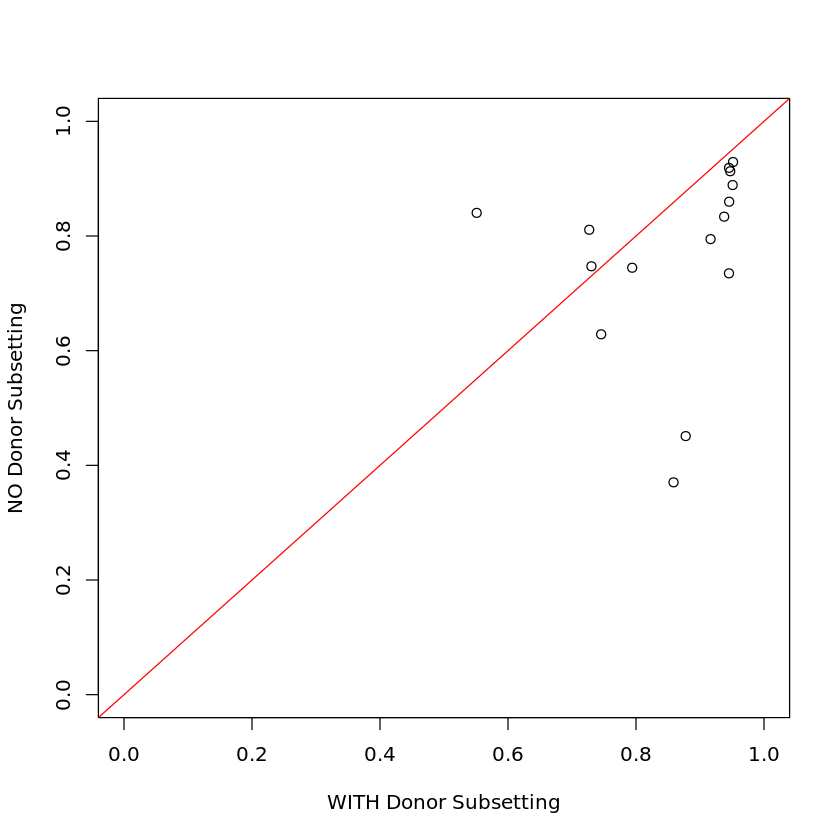

In [20]:
plot(
    sapply(imputed_tsvs[names(imputed_tsvs) %in% vireo_dirs], getFracAssignableVireo), 
    sapply(imputed_nosub_tsvs, getFracAssignableVireo), 
    xlim=c(0, 1), ylim=c(0, 1), xlab="WITH Donor Subsetting", ylab="NO Donor Subsetting")
abline(0, 1, col="red")



In [21]:
imputed_tsvs_sub = imputed_tsvs[names(imputed_tsvs) %in% vireo_dirs]

In [45]:
paste(sort(setdiff(imputed_nosub_grouped$donor_id, imputed_sub_grouped$donor_id)), collapse = ' -- ')

[1] ""

In [77]:
for (name in vireo_dirs){
    vireo_nosub = imputed_nosub_tsvs[[name]]
    vireo_sub = imputed_tsvs[[name]] %>% filter(cell %in% vireo_nosub$cell)
    vireo_nosub = vireo_nosub %>% filter(cell %in% vireo_sub$cell)
}

[1] "1918 1918"
[1] "4573 4573"
[1] "3529 3529"
[1] "5914 5914"
[1] "3618 3618"
[1] "3959 3959"
[1] "5952 5952"
[1] "7876 7876"
[1] "5426 5426"
[1] "7887 7887"
[1] "8091 8091"
[1] "3113 3113"
[1] "3229 3229"
[1] "4043 4043"
[1] "5271 5271"


In [103]:
# add participant ID
manifest = read.table("~/Calico_Macosko_PD_GSA_Terra_Manifest_20240220.tsv", sep='\t',header=T,skip=0)
sort(colnames(manifest))

manifest$donor_id = sapply(manifest$entity.sample_id, function(x) gsub("_1$", "", x))
manifest$sex = manifest$Sex
manifest$age = manifest$Age 
manifest$participant_id = ifelse(
    manifest$CORRECT.donor =='', 
    manifest$collaborator_participant_id,
    manifest$CORRECT.donor
)
manifest$case_control = ifelse(manifest$Disease == 'Control', 'ctr', 'pd')

[1] "Age"                         "autocall_call_rate"         
 [3] "autocall_gender"             "autocall_version"           
 [5] "call_date"                   "call_rate"                  
 [7] "called_infinium_snps"        "chip"                       
 [9] "chip_well_barcode"           "collaborator_participant_id"
[11] "collaborator_sample_id"      "CORRECT.donor"              
[13] "Disease"                     "entity.sample_id"           
[15] "fp_gender"                   "fp_lod_score"               
[17] "gender_concordance"          "green_idat"                 
[19] "gtc"                         "hap_map_concordance"        
[21] "het_rate"                    "last_cluster_file"          
[23] "participant"                 "pdo"                        
[25] "red_idat"                    "release_date"               
[27] "reported_gender"             "reported_gender.1"          
[29] "research_project_id"         "scan_date"                  
[31] "Sex"                         "stock_sample"               
[33] "vcf"                         "vcf_index"                  
[35] "version"                     "zcall_version"

In [104]:

manifest = manifest[, c('donor_id', 'participant_id', 'case_control', 'sex', 'age')]

donor_to_participant_map = setNames(manifest$participant_id, manifest$donor_id)

summary_df_list = list()

for (name in vireo_dirs){
    imputed_nosub_orig = imputed_nosub_tsvs[[name]] 
    imputed_sub_orig = imputed_tsvs_sub[[name]]

    imputed_nosub_orig = imputed_nosub_orig %>% filter(cell %in% imputed_sub_orig$cell)
    imputed_sub_orig = imputed_sub_orig %>% filter(cell %in% imputed_nosub_orig$cell)

    donor_list = readLines(file.path(BASE_PATH, name, "donor_list.txt"))

    n_donors = length(donor_list)

    imputed_sub = imputed_sub_orig[(imputed_sub_orig$prob_max >= 0.9) & (!imputed_sub_orig$donor_id %in% c("unassigned", "doublet")),]
    imputed_nosub = imputed_nosub_orig[(imputed_nosub_orig$prob_max >= 0.9) & (!imputed_nosub_orig$donor_id %in% c("unassigned", "doublet")),]
    imputed_sub$participant_id = donor_to_participant_map[imputed_sub$donor_id]
    imputed_nosub$participant_id = donor_to_participant_map[imputed_nosub$donor_id]

    imputed_sub_grouped = imputed_sub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells))
    imputed_nosub_grouped = imputed_nosub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells))
    imputed_nosub_grouped = imputed_nosub_grouped[1:n_donors,]

    print(name)
    print(paste("Same Donors?", all(sort(imputed_sub_grouped$participant_id) == sort(imputed_nosub_grouped$participant_id))))
    print(paste('WITH donor subsetting', round(getFracAssignableVireo(imputed_sub_orig), 2)))
    print(imputed_sub_grouped)
    print(paste('NO donor subsetting', round(getFracAssignableVireo(imputed_nosub_orig), 2)))
    print(imputed_nosub_grouped)
    print(":::::::::::::::::::::::::::::::::::::::::::")

    frac_assignable_sub = round(getFracAssignableVireo(imputed_sub_orig), 2)
    frac_assignable_nosub = round(getFracAssignableVireo(imputed_nosub_orig), 2)
    only_in_sub = paste(sort(setdiff(imputed_sub_grouped$participant_id, imputed_nosub_grouped$participant_id)), collapse = ' -- ')
    only_in_nosub = paste(sort(setdiff(imputed_nosub_grouped$participant_id, imputed_sub_grouped$participant_id)), collapse = ' -- ')

    summary_df = data.frame(
        frac_assignable_sub = frac_assignable_sub,
        frac_assignable_nosub = frac_assignable_nosub,
        same_donors = all(sort(imputed_sub_grouped$participant_id) == sort(imputed_nosub_grouped$participant_id)),
        only_in_sub = only_in_sub,
        only_in_nosub = only_in_nosub
        # donors_sub = paste(sort(imputed_sub_grouped$donor_id), collapse = ' -- '),
        # donors_nosub = paste(sort(imputed_nosub_grouped$donor_id), collapse = ' -- ')
    )
    summary_df_list[[name]] = summary_df
}
summary_df = do.call(rbind, summary_df_list)

[1] "pCalicoPDsHSrSNiPoold230719B"
[1] "Same Donors? TRUE"
[1] "WITH donor subsetting 0.79"
# A tibble: 6 × 2
  participant_id n_cells
  <chr>            <int>
1 2002-086           477
2 PDC139             466
3 2009-016           261
4 PDC165             159
5 2008-052           140
6 PDC114              20
[1] "NO donor subsetting 0.78"
# A tibble: 6 × 2
  participant_id n_cells
  <chr>            <int>
1 PDC139             464
2 2002-086           462
3 2009-016           261
4 PDC165             155
5 2008-052           139
6 PDC114              18
[1] ":::::::::::::::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719CD"
[1] "Same Donors? FALSE"
[1] "WITH donor subsetting 0.73"
# A tibble: 6 × 2
  participant_id n_cells
  <chr>            <int>
1 "PD0793"          1354
2 "PD0903"          1134
3 "PD0968"           440
4 "PDC165"           399
5 "Uncertain "         9
6 "PD0940"             4
[1] "NO donor subsetting 0.84"
# A tibble: 6 × 2
  participant_id n_cells
  <ch

In [105]:
summary_df

,frac_assignable_sub,frac_assignable_nosub,same_donors,only_in_sub,only_in_nosub
,<dbl>,<dbl>,<lgl>,<chr>,<chr>
pCalicoPDsHSrSNiPoold230719B,0.79,0.78,TRUE,,
pCalicoPDsHSrSNiPoold230719CD,0.73,0.84,FALSE,PD0940 -- Uncertain,PD0954 -- PD0980
pCalicoPDsHSrSNiPoold230719D2,0.75,0.92,FALSE,PD0940 -- PDC110 -- Uncertain,PD0736 -- PD0954 -- PDC091
pCalicoPDsHSrSNiPoold230719DD,0.55,0.87,FALSE,PD0940 -- PDC110 -- Uncertain,2007-020 -- PD0954 -- PDC091
pCalicoPDsHSrSNiPoold230719E1,0.95,0.93,TRUE,,
pCalicoPDsHSrSNiPoold230719E2,0.95,0.94,TRUE,,
pCalicoPDsHSrSNiPoold230719ED,0.95,0.94,TRUE,,
pCalicoPDsHSrSNiPoold230719FD,0.95,0.95,TRUE,,
pCalicoPDsHSrSNiPoold230719G1,0.95,0.93,TRUE,,


In [106]:
name = "pCalicoPDsHSrSNiPoold230719CD"
diff_donor_libs = rownames(summary_df)[summary_df$same_donors == FALSE]
for (name in diff_donor_libs){
    imputed_sub = imputed_tsvs_sub[[name]] %>% filter(prob_max >= 0.9 & !donor_id %in% c("unassigned", "doublet"))
    imputed_nosub = imputed_nosub_tsvs[[name]] %>% filter(prob_max >= 0.9 & !donor_id %in% c("unassigned", "doublet"))
    print(name)
    print(imputed_sub %>% mutate(participant_id = donor_to_participant_map[imputed_sub$donor_id]) %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells)))
    print(imputed_nosub %>% mutate(participant_id = donor_to_participant_map[imputed_nosub$donor_id]) %>%  group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells)))
    print(":::::::::::::::::::::::::::::::::::::::::::")
}

[1] "pCalicoPDsHSrSNiPoold230719CD"
# A tibble: 6 × 2
  participant_id n_cells
  <chr>            <int>
1 "PD0793"          1354
2 "PD0903"          1134
3 "PD0968"           440
4 "PDC165"           399
5 "Uncertain "         9
6 "PD0940"             4
# A tibble: 32 × 2
   participant_id n_cells
   <chr>            <int>
 1 PD0793            1454
 2 PD0903            1253
 3 PD0954             722
 4 PDC165             562
 5 PD0968             523
 6 2007-020             2
 7 PD0878               2
 8 PD0957               2
 9 PD0980               2
10 PD0985               2
# ℹ 22 more rows
[1] ":::::::::::::::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719D2"
# A tibble: 6 × 2
  participant_id n_cells
  <chr>            <int>
1 "PD0793"          1476
2 "PD0903"           865
3 "PD0968"           274
4 "PD0940"             7
5 "Uncertain "         5
6 "PDC110"             4
# A tibble: 41 × 2
   participant_id n_cells
   <chr>            <int>
 1 PD0793            14

In [87]:
only_in_sub

[1] "PDC091"

In [107]:
for (name in diff_donor_libs){
    imputed_sub = imputed_tsvs_sub[[name]] %>% filter(prob_max >= 0.9 & !donor_id %in% c("unassigned", "doublet"))
    imputed_nosub = imputed_nosub_tsvs[[name]] %>% filter(prob_max >= 0.9 & !donor_id %in% c("unassigned", "doublet"))
    imputed_sub$participant_id = donor_to_participant_map[imputed_sub$donor_id]
    imputed_nosub$participant_id = donor_to_participant_map[imputed_nosub$donor_id]
    this_summary = summary_df[rownames(summary_df) == name,]
    
    only_in_sub = strsplit(this_summary$only_in_sub, ' -- ')[[1]]
    only_in_nosub = strsplit(this_summary$only_in_nosub, ' -- ')[[1]]

    imputed_sub = imputed_sub %>% filter(participant_id %in% only_in_sub)
    imputed_nosub = imputed_nosub %>% filter(participant_id %in% only_in_nosub)
    print(name)
    print("Only In Sub")
    print(imputed_sub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells)))
    print("Only In No-Sub")
    print(imputed_nosub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells)))
    print(":::::::::::::::::::::::::::::::::::::::::::")

}

[1] "pCalicoPDsHSrSNiPoold230719CD"
[1] "Only In Sub"
# A tibble: 2 × 2
  participant_id n_cells
  <chr>            <int>
1 "Uncertain "         9
2 "PD0940"             4
[1] "Only In No-Sub"
# A tibble: 2 × 2
  participant_id n_cells
  <chr>            <int>
1 PD0954             722
2 PD0980               2
[1] ":::::::::::::::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719D2"
[1] "Only In Sub"
# A tibble: 3 × 2
  participant_id n_cells
  <chr>            <int>
1 "PD0940"             7
2 "Uncertain "         5
3 "PDC110"             4
[1] "Only In No-Sub"
# A tibble: 3 × 2
  participant_id n_cells
  <chr>            <int>
1 PD0954             588
2 PDC091             299
3 PD0736               2
[1] ":::::::::::::::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719DD"
[1] "Only In Sub"
# A tibble: 3 × 2
  participant_id n_cells
  <chr>            <int>
1 "Uncertain "        15
2 "PDC110"            12
3 "PD0940"             9
[1] "Only In No-Sub"
# A tibble

In [62]:
imputed_sub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells))

participant_id,n_cells
<chr>,<int>
PDC092,1096
2019-114,692
2018-130,626
2008-028,555
2017-037,326
PD0809,126


In [63]:
imputed_nosub %>% group_by(participant_id) %>% summarize(n_cells = n()) %>% arrange(desc(n_cells))

participant_id,n_cells
<chr>,<int>
PDC092,1100
2019-114,691
2018-130,624
2008-028,553
2017-037,308
PD0809,116
PD0730,2
PD0833,2
PD0901,2


[1] "Age"                         "autocall_call_rate"         
 [3] "autocall_gender"             "autocall_version"           
 [5] "call_date"                   "call_rate"                  
 [7] "called_infinium_snps"        "chip"                       
 [9] "chip_well_barcode"           "collaborator_participant_id"
[11] "collaborator_sample_id"      "CORRECT.donor"              
[13] "Disease"                     "entity.sample_id"           
[15] "fp_gender"                   "fp_lod_score"               
[17] "gender_concordance"          "green_idat"                 
[19] "gtc"                         "hap_map_concordance"        
[21] "het_rate"                    "last_cluster_file"          
[23] "participant"                 "pdo"                        
[25] "red_idat"                    "release_date"               
[27] "reported_gender"             "reported_gender.1"          
[29] "research_project_id"         "scan_date"                  
[31] "Sex"                         "stock_sample"               
[33] "vcf"                         "vcf_index"                  
[35] "version"                     "zcall_version"

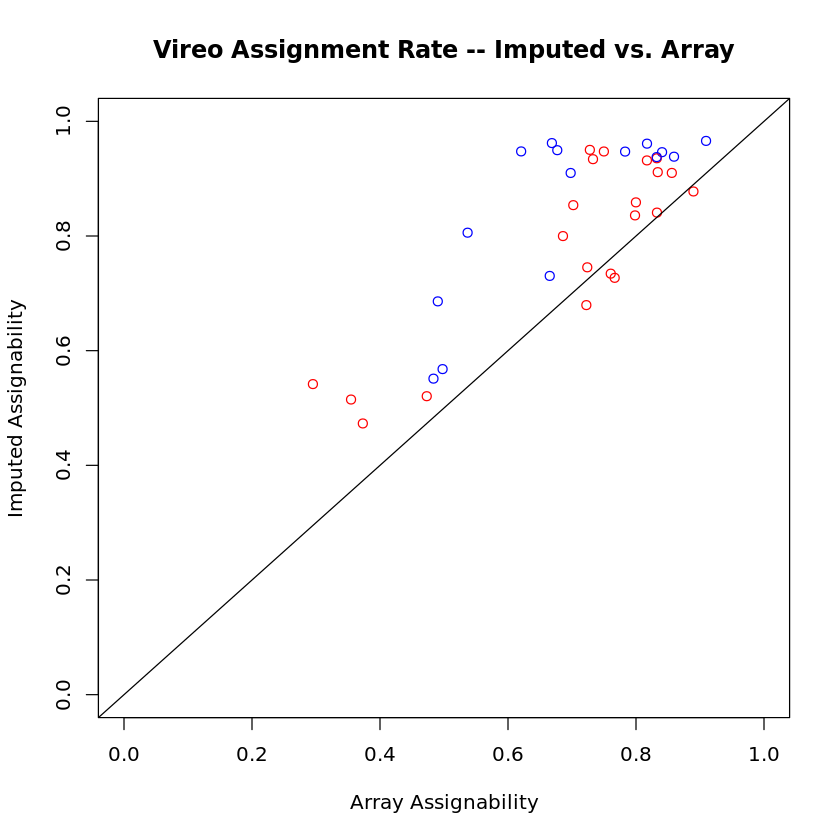

In [5]:
x = list()
y = list()
colors = list()

cdict = c("dapi"="blue", "nurr"="red")

for (name in vireo_dirs){
    array = array_tsvs[[name]]
    imputed = imputed_tsvs[[name]]
    x[[name]] = getFracAssignableVireo(array)
    y[[name]] = getFracAssignableVireo(imputed)
    colors[[name]] = cdict[[dapi_nurr[[name]]]]
}

plot(x, y,
    xlab="Array Assignability",
    ylab="Imputed Assignability", 
    main="Vireo Assignment Rate -- Imputed vs. Array", xlim=c(0, 1), ylim=c(0, 1), col=unlist(colors))
abline(0, 1, col="black")

In [ ]:
lib_donor_grouped_df_list = list()
for (name in calico_libs){

    array = array_tsvs[[name]]
    array_clean = array[(!array$donor_id %in% c('doublet', 'unassigned')) & (array$prob_max >= 0.9),]

    # group by donor_id. Get number of cells, and fraction of cells
    donor_grouped_df = (array_clean
        %>% group_by(donor_id) 
        %>% summarize(
            n_cells = n(),
            total_assignable_cells = nrow(array_clean),
            frac_of_assignable_cells = round(n()/nrow(array_clean), 3)
        )
        %>% as.data.frame()
    )
    donor_grouped_df$lib = name
    donor_grouped_df$sort = dapi_nurr[[name]]
    rownames(donor_grouped_df) = paste0(donor_grouped_df$lib, "-", donor_grouped_df$donor_id)
    
    lib_donor_grouped_df_list[[name]] = donor_grouped_df
}
lib_donor_grouped_df_long = do.call(rbind, lib_donor_grouped_df_list)

ERROR: Error in parse(text = x, srcfile = src): <text>:13:13: unexpected symbol
12:             total_assignable_cells = nrow(array_clean)
13:             frac_of_assignable_cells
                ^


In [13]:
donor_grouped_df_long = (
    lib_donor_grouped_df_long
    %>% group_by(donor_id)
    %>% summarize(
        n_libraries = n(),
        n_cells = sum(n_cells),
        frac_of_total_droplets = round(sum(frac_of_total_droplets), 3),
        frac_of_assignable_cells = round(sum(frac_of_assignable_cells), 3)
    )

,donor_id,n_cells,frac_of_total_droplets,frac_of_assignable_cells,lib,sort
,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-206954930010_R02C01,206954930010_R02C01,522,0.213,0.295,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-206954930011_R11C02,206954930011_R11C02,225,0.092,0.127,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-206954930093_R08C01,206954930093_R08C01,81,0.033,0.046,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-207762950086_R06C02,207762950086_R06C02,153,0.063,0.087,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-207762950086_R07C02,207762950086_R07C02,273,0.112,0.154,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719B.pCalicoPDsHSrSNiPoold230719B-207762950086_R11C01,207762950086_R11C01,513,0.210,0.290,pCalicoPDsHSrSNiPoold230719B,nurr
pCalicoPDsHSrSNiPoold230719BD.pCalicoPDsHSrSNiPoold230719BD-206954930010_R02C01,206954930010_R02C01,756,0.140,0.154,pCalicoPDsHSrSNiPoold230719BD,dapi
pCalicoPDsHSrSNiPoold230719BD.pCalicoPDsHSrSNiPoold230719BD-206954930011_R11C02,206954930011_R11C02,406,0.075,0.083,pCalicoPDsHSrSNiPoold230719BD,dapi
pCalicoPDsHSrSNiPoold230719BD.pCalicoPDsHSrSNiPoold230719BD-206954930093_R08C01,206954930093_R08C01,73,0.014,0.015,pCalicoPDsHSrSNiPoold230719BD,dapi


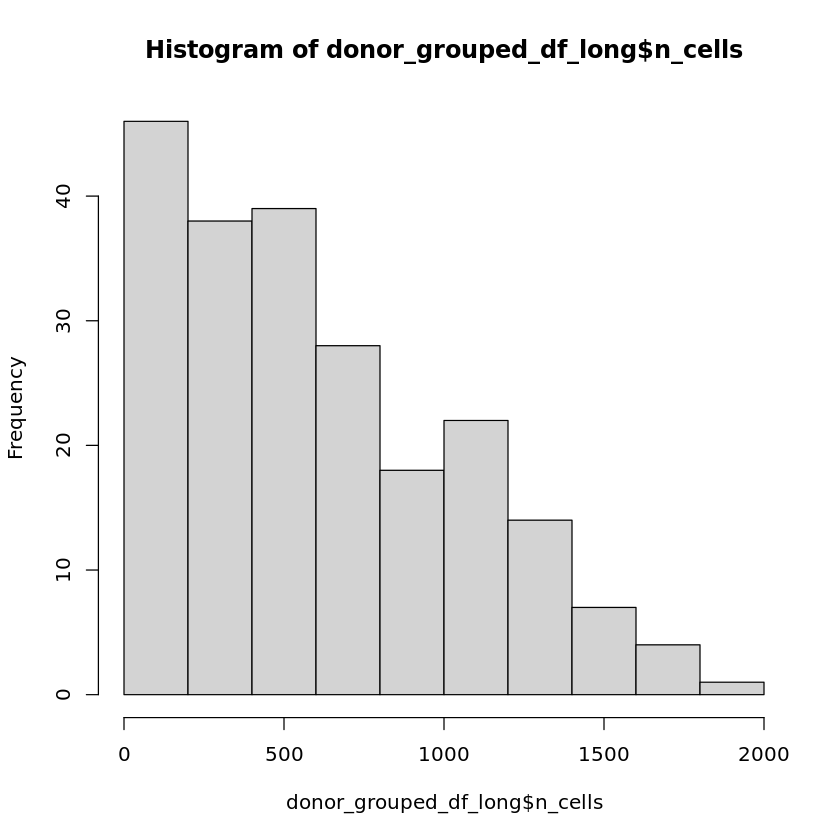

In [15]:
hist(donor_grouped_df_long$n_cells)

In [94]:
for (p in sort(manifest$participant_id)){
    print(p)
    print(manifest$donor_id[manifest$participant_id == p])
}

[1] "1995-078"
[1] "207762950055_R06C01"
[1] "1997-115"
[1] "207762950108_R11C01"
[1] "1998-016"
[1] "207762950108_R09C01"
[1] "1998-051"
[1] "207762960003_R03C02"
[1] "2002-086"
[1] "207762950086_R11C01"
[1] "2007-020"
[1] "207762950108_R04C01"
[1] "2007-032"
[1] "207762960003_R06C02"
[1] "2007-046"
[1] "207762960003_R08C02"
[1] "2007-075"
[1] "207762950055_R01C01"
[1] "2008-028"
[1] "207762950055_R04C01"
[1] "2008-052"
[1] "207762950086_R06C02"
[1] "2009-016"
[1] "207762950086_R07C02"
[1] "2014-020"
[1] "207762950108_R05C02"
[1] "2017-037"
[1] "207762960003_R01C02" "207762960003_R09C01"
[1] "2017-037"
[1] "207762960003_R01C02" "207762960003_R09C01"
[1] "2018-130"
[1] "207762950055_R08C02" "207762950086_R03C02"
[1] "2018-130"
[1] "207762950055_R08C02" "207762950086_R03C02"
[1] "2019-017"
[1] "207762950086_R12C02" "207762950108_R01C02"
[1] "2019-017"
[1] "207762950086_R12C02" "207762950108_R01C02"
[1] "2019-019"
[1] "207762950108_R08C02"
[1] "2019-071"
[1] "207762950086_R08C02" "207762

In [46]:
mean((as.numeric(y)-as.numeric(x))/as.numeric(x))
median((as.numeric(y)-as.numeric(x))/as.numeric(x))

[1] 0.1228698

[1] 0.09184845

In [1]:
a=3

In [13]:
sapply(array_tsvs, getFracAssignableVireo)

pCalicoPDsHSrSNiPoold230719B pCalicoPDsHSrSNiPoold230719BD 
                    0.7224039                     0.9094620 
 pCalicoPDsHSrSNiPoold230719C pCalicoPDsHSrSNiPoold230719CD 
                    0.3731718                     0.6652088 
pCalicoPDsHSrSNiPoold230719D1 pCalicoPDsHSrSNiPoold230719D2 
                    0.3547401                     0.7238681 
pCalicoPDsHSrSNiPoold230719DD pCalicoPDsHSrSNiPoold230719E1 
                    0.4835443                     0.8559681 
pCalicoPDsHSrSNiPoold230719E2 pCalicoPDsHSrSNiPoold230719ED 
                    0.8339673                     0.8593981 
pCalicoPDsHSrSNiPoold230719F1 pCalicoPDsHSrSNiPoold230719F2 
                    0.7984767                     0.8327507 
pCalicoPDsHSrSNiPoold230719FD pCalicoPDsHSrSNiPoold230719G1 
                    0.8407157                     0.8324774 
pCalicoPDsHSrSNiPoold230719G2 pCalicoPDsHSrSNiPoold230719GD 
                    0.7019878                     0.8322769 
pCalicoPDsHSrSNiPoold230719I1 pCalicoPDsHSrSNiPoold230719I2 
                    0.7278978                     0.7498187 
pCalicoPDsHSrSNiPoold230719ID pCalicoPDsHSrSNiPoold230719J1 
                    0.7829687                     0.7998715 
pCalicoPDsHSrSNiPoold230719J2 pCalicoPDsHSrSNiPoold230719JD 
                    0.8897491                     0.4903130 
pCalicoPDsHSrSNiPoold230719K1 pCalicoPDsHSrSNiPoold230719K2 
                    0.7605239                     0.7666913 
  pCalicoPDsHSrSNA8id230921A8   pCalicoPDsHSrSNA9id230921A9 
                    0.6685865                     0.6769984 
  pCalicoPDsHSrSNB8id230921B8   pCalicoPDsHSrSNB9id230921B9 
                    0.6858847                     0.7327968 
  pCalicoPDsHSrSNC8id230921C8   pCalicoPDsHSrSNC9id230921C9 
                    0.4730463                     0.6979147 
  pCalicoPDsHSrSND8id230921D8   pCalicoPDsHSrSND9id230921D9 
                    0.4977974                     0.5368814 
  pCalicoPDsHSrSNE8id230921E8   pCalicoPDsHSrSNF8id230921F8 
                    0.8171978                     0.2951679 
  pCalicoPDsHSrSNG8id230921G8   pCalicoPDsHSrSNH8id230921H8 
                    0.8170801                     0.6205369

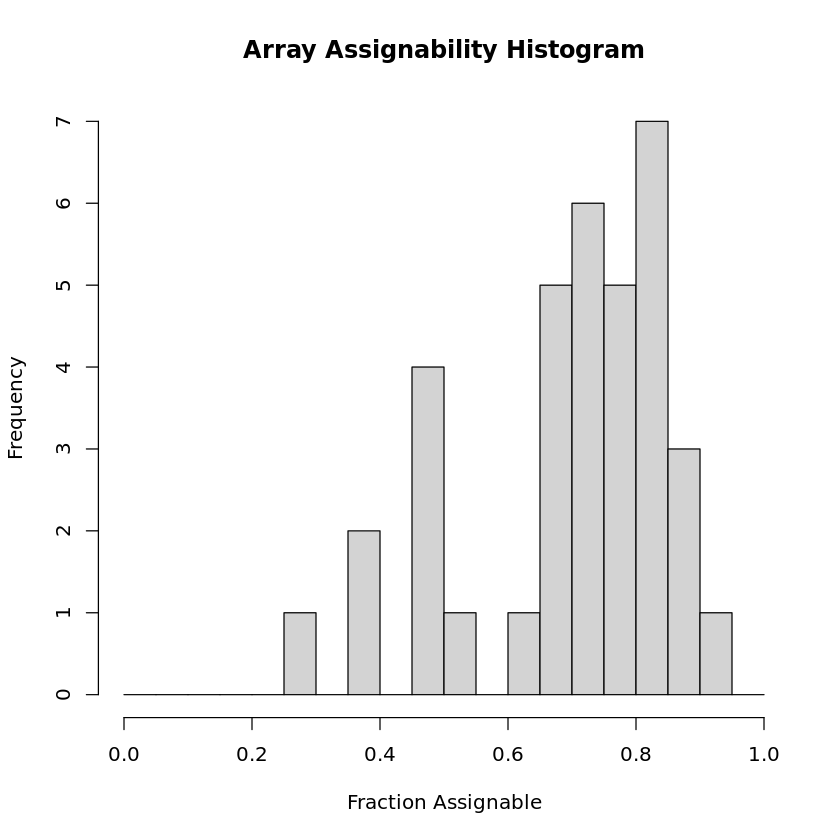

In [7]:
hist(sapply(array_tsvs, getFracAssignableVireo), breaks=seq(0, 1, 0.05), main="Array Assignability Histogram", xlab="Fraction Assignable")

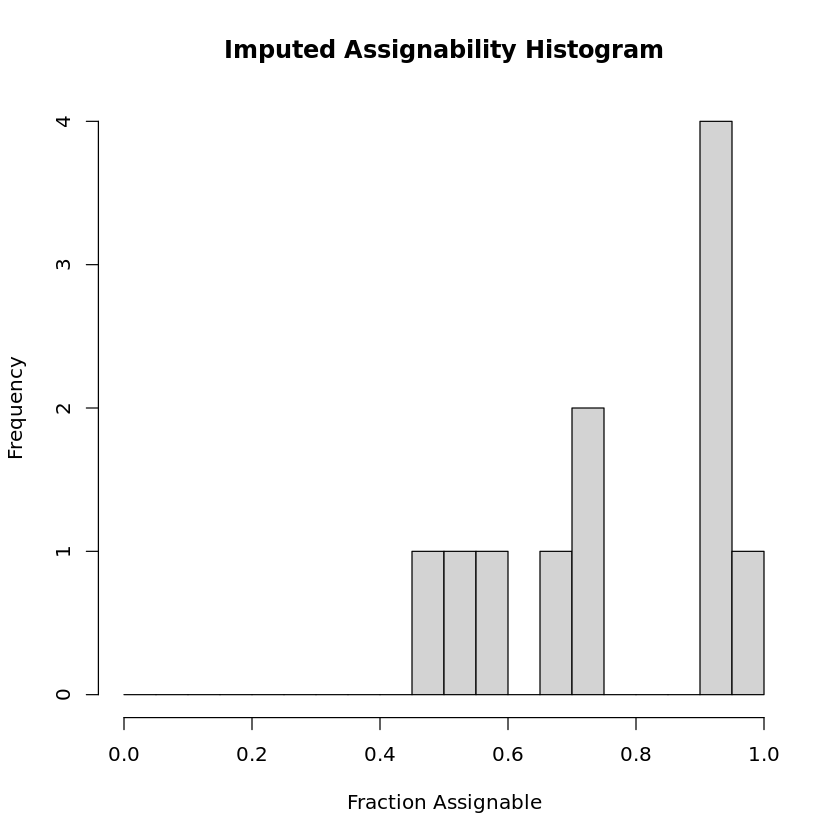

In [8]:
hist(sapply(imputed_tsvs, getFracAssignableVireo), breaks=seq(0, 1, 0.05), main="Imputed Assignability Histogram", xlab="Fraction Assignable")

`summarise()` has grouped output by 'group_col'. You can override using the
`.groups` argument.


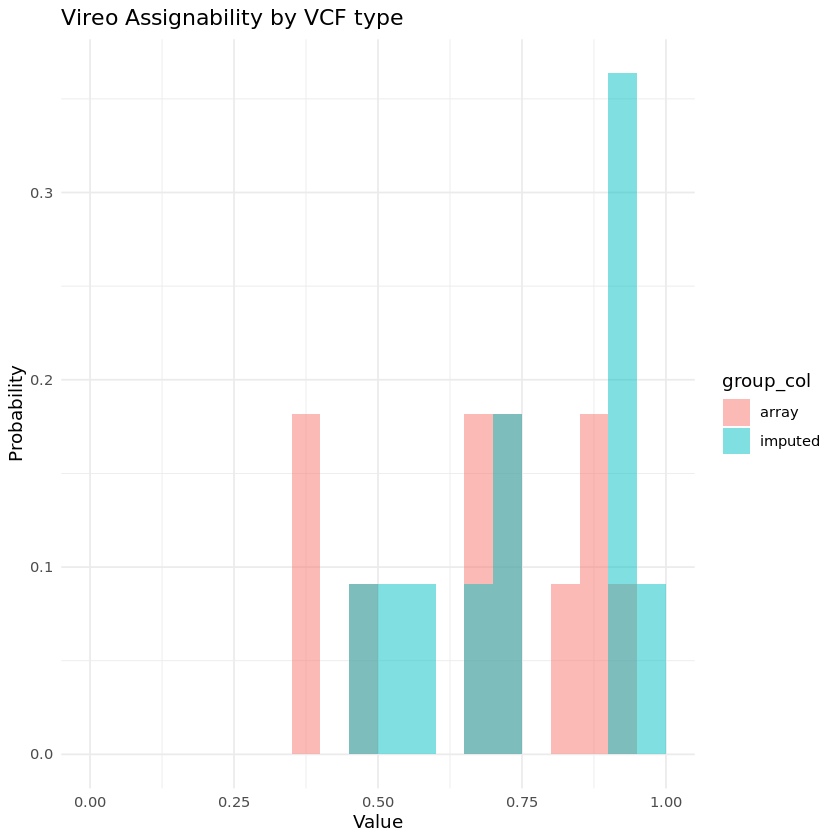

In [11]:
long_df = rbind(
    data.frame(
        lib=names(array_tsvs[names(array_tsvs) %in% names(imputed_tsvs)]),
        assignability=sapply(array_tsvs[names(array_tsvs) %in% names(imputed_tsvs)], getFracAssignableVireo),
        geno='array'
    ),
    data.frame(
        lib=names(imputed_tsvs),
        assignability=sapply(imputed_tsvs, getFracAssignableVireo),
        geno='imputed'
    )
)
plotOverlappingProbabilityHistograms(
    long_df,
    plot_col = "assignability",
    group_col = "geno",
    title="Vireo Assignability by VCF type"
)

In [35]:
getFracAssignableVireo(imputed_long)*nrow(imputed_long) - getFracAssignableVireo(array_long)*nrow(array_long)

[1] 3802

In [36]:
getFracAssignableVireo(imputed_long)*nrow(imputed_long)

[1] 37272

In [37]:
getFracAssignableVireo(array_long)*nrow(array_long)

[1] 33470

`summarise()` has grouped output by 'group_col'. You can override using the
`.groups` argument.


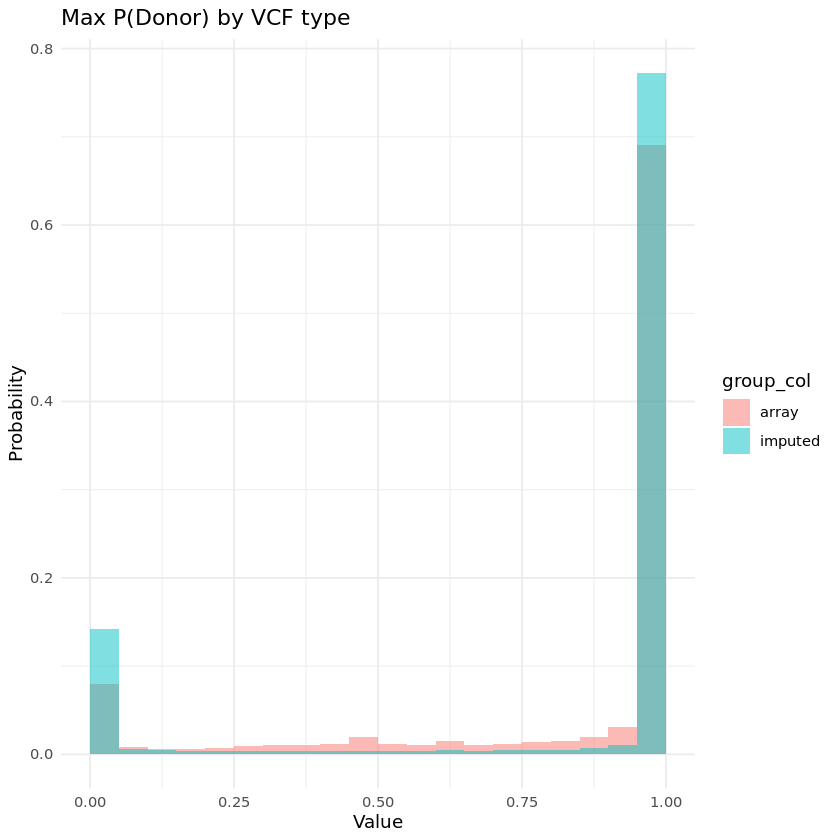

In [29]:
array_long = do.call(rbind, array_tsvs[names(array_tsvs) %in% names(imputed_tsvs)])
imputed_long = do.call(rbind, imputed_tsvs)
array_long$geno = "array"
imputed_long$geno = "imputed"
long_df = rbind(array_long, imputed_long)

long_df$log10_nvars = log10(long_df$n_vars)

plotOverlappingProbabilityHistograms(
    long_df,
    plot_col = "prob_max",
    group_col = "geno",
    title="Max P(Donor) by VCF type",
    xlim=c(0, 1),
    breaks=seq(0, 1, 0.05)
)

In [35]:
x[names(dapi_nurr[dapi_nurr=='dapi' & names(dapi_nurr) %in% vireo_dirs])]

$pCalicoPDsHSrSNiPoold230719BD
[1] 0.909462

$pCalicoPDsHSrSNiPoold230719CD
[1] 0.6652088

$pCalicoPDsHSrSNC9id230921C9
[1] 0.6979147

In [36]:
y[names(dapi_nurr[dapi_nurr=='dapi' & names(dapi_nurr) %in% vireo_dirs])]

$pCalicoPDsHSrSNiPoold230719BD
[1] 0.9658627

$pCalicoPDsHSrSNiPoold230719CD
[1] 0.7303739

$pCalicoPDsHSrSNC9id230921C9
[1] 0.9099465

In [37]:
x[names(dapi_nurr[dapi_nurr=='nurr' & names(dapi_nurr) %in% vireo_dirs])]

$pCalicoPDsHSrSNiPoold230719B
[1] 0.7224039

$pCalicoPDsHSrSNiPoold230719C
[1] 0.3731718

$pCalicoPDsHSrSNiPoold230719D1
[1] 0.3547401

$pCalicoPDsHSrSNiPoold230719D2
[1] 0.7238681

In [38]:
y[names(dapi_nurr[dapi_nurr=='nurr' & names(dapi_nurr) %in% vireo_dirs])]

$pCalicoPDsHSrSNiPoold230719B
[1] 0.6794767

$pCalicoPDsHSrSNiPoold230719C
[1] 0.4730464

$pCalicoPDsHSrSNiPoold230719D1
[1] 0.5147808

$pCalicoPDsHSrSNiPoold230719D2
[1] 0.7453885

In [81]:
getAndPlotConfusionMatrix = function(
    merged_df,
    name,
    col_x,
    col_y,
    non_assignable_categories = c('doublet', 'unassigned'),
    xlab=NULL,
    ylab=NULL,
    title=NULL,
    fig_filename=NULL
){
    # TODO: add norm args for either cols, rows, or the whole matrix

    # Create the confusion matrix
    x_factors = factor(merged_df[[col_x]])
    y_factors = factor(merged_df[[col_y]])

    # "data" and "reference" are misnomers; we're just comparing the two methods
    # "reference" labels displayed on X-Axis, "data" on Y-Axis
    # Below, the xlab MUST correspond to the "reference", and the ylab to the "data"
    conf_mat <- confusionMatrix(data=y_factors, reference=x_factors)

    # Get the table of raw counts and convert it to proportions
    conf_mat_table <- conf_mat$table
    prop_table_col_norm <- conf_mat_table #apply(conf_mat_table, 2, function(x) x / sum(x)) # divide each column by its sum. Need to be specific about axis bc matrix is square

    if (is.null(xlab)) { xlab = col_x }
    if (is.null(ylab)) { ylab = col_y }
    if (is.null(title)){
        title = paste("Confusion Matrix for library", name, '\n', ylab, "vs:", xlab, sep=' ')
    }

    merged_df_doubly_assignable = merged_df[
        !(merged_df[[col_x]] %in% non_assignable_categories) & 
        !(merged_df[[col_y]] %in% non_assignable_categories),]

    conf_mat_doubly_assignable = confusionMatrix(
        data=factor(merged_df_doubly_assignable[[col_y]]), 
        reference=factor(merged_df_doubly_assignable[[col_x]])
    )

    title = paste0(title,                 
        '\nFrac of Cells with Same Predictions: ', round(conf_mat$overall['Accuracy'], 3),
        '\nFrac Assignable by both methods: ', round(dim(merged_df_doubly_assignable)[1] / dim(merged_df)[1], 2),
        '\nFrac of Doubly Assignable Cells with Same Predictions: ', round(conf_mat_doubly_assignable$overall['Accuracy'], 3)
    )

    # Call the function to plot the heatmap
    # the xlab MUST correspond to the reference, and the ylab to the data
    plotConfusionHeatmap(
        prop_table_col_norm, 
        xlab=xlab, 
        ylab=ylab, 
        title=title,
        fig_filename=fig_filename
    )
}

In [79]:
name

[1] "pCalicoPDsHSrSNH8id230921H8"

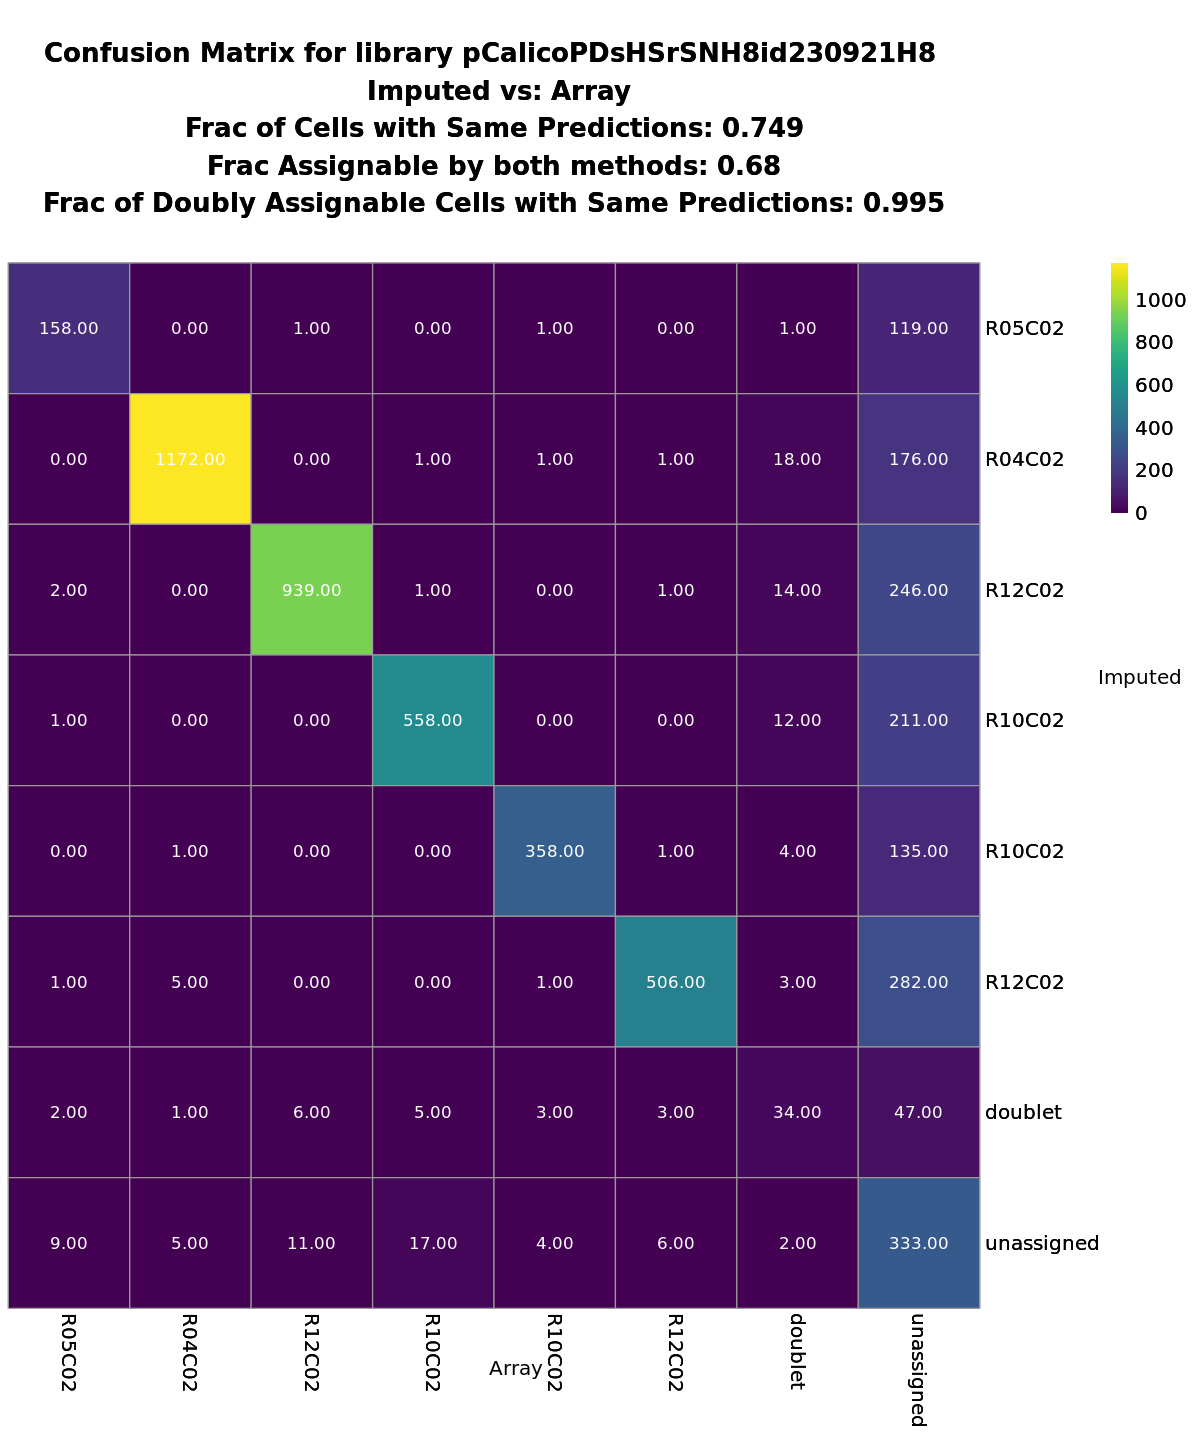

In [67]:
dim(merged)

[1] 5419   15

In [69]:
head(merged)

,cell,donor_id_array,prob_max_array,prob_doublet_array,n_vars_array,best_singlet_array,best_doublet_array,doublet_logLikRatio_array,donor_id_imputed,prob_max_imputed,prob_doublet_imputed,n_vars_imputed,best_singlet_imputed,best_doublet_imputed,doublet_logLikRatio_imputed
,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,AAACCCAAGTAGCCAG-1,unassigned,0.437,1.15e-01,11,207762960003_R12C02,"207762960003_R12C02,207762950108_R10C02",2.440,207762960003_R12C02,0.975,1.88e-02,52,207762960003_R12C02,"207762960003_R12C02,207762950086_R10C02",-0.173
2,AAACCCACATAATGCC-1,unassigned,0.764,9.81e-03,4,207762950108_R10C02,"207762950086_R10C02,207762950108_R10C02",-0.580,207762960003_R12C02,1.000,2.45e-05,120,207762960003_R12C02,"207762960003_R12C02,207762950108_R10C02",-6.843
3,AAACCCAGTCCGGACT-1,206954930093_R04C02,1.000,2.31e-20,327,206954930093_R04C02,"207762960003_R12C02,206954930093_R04C02",-41.439,206954930093_R04C02,1.000,1.71e-311,5922,206954930093_R04C02,"206954930093_R04C02,207762950055_R12C02",-711.789
4,AAACCCATCAATCCAG-1,207762950055_R12C02,1.000,4.00e-06,44,207762950055_R12C02,"206954930093_R04C02,207762950108_R10C02",-8.653,207762950055_R12C02,1.000,2.45e-46,774,207762950055_R12C02,"206954930093_R04C02,207762950108_R10C02",-101.248
5,AAACCCATCACTCACC-1,207762950086_R10C02,1.000,1.38e-40,486,207762950086_R10C02,"207762950086_R10C02,207762960003_R12C02",-88.002,207762950086_R10C02,1.000,0.00e+00,8716,207762950086_R10C02,"207762960003_R12C02,206954930093_R04C02",-1114.551
6,AAACCCATCGGTGAAG-1,207762950055_R12C02,1.000,2.21e-06,21,207762950055_R12C02,"207762950086_R10C02,207762950055_R12C02",-9.248,207762950055_R12C02,1.000,2.42e-15,287,207762950055_R12C02,"207762960003_R12C02,207762950055_R12C02",-29.881


In [72]:
table(merged$donor_id_array == merged$donor_id_imputed)


FALSE  TRUE 
 1361  4058 

In [101]:
for (name in vireo_dirs){
    merged = merge(array_tsvs[[name]], imputed_tsvs[[name]], by="cell", suffixes = c("_array", "_imputed"))
    print(name)
    
    # when both are sure
    print(table(merged[!(merged$donor_id_imputed %in% c('unassigned', 'doublet') | merged$donor_id_array%in% c('unassigned', 'doublet')) ,]$donor_id_array == merged[!(merged$donor_id_imputed %in% c('unassigned', 'doublet') | merged$donor_id_array%in% c('unassigned', 'doublet')),]$donor_id_imputed))
    
    # when the array is sure
    print(table(merged[!(merged$donor_id_array%in% c('unassigned', 'doublet')) ,]$donor_id_array == merged[!(merged$donor_id_array%in% c('unassigned', 'doublet')),]$donor_id_imputed))
    
    # when the imputed is sure
    print(table(merged[!(merged$donor_id_imputed%in% c('unassigned', 'doublet')) ,]$donor_id_array == merged[!(merged$donor_id_imputed%in% c('unassigned', 'doublet')),]$donor_id_imputed))
    print(":::::::::::::::::::::::::::::::")
}

[1] "pCalicoPDsHSrSNiPoold230719B"

FALSE  TRUE 
   11  1535 

FALSE  TRUE 
  232  1535 

FALSE  TRUE 
  127  1535 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719BD"

FALSE  TRUE 
   11  4848 

FALSE  TRUE 
   54  4848 

FALSE  TRUE 
  358  4848 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719C"

FALSE  TRUE 
   67  1302 

FALSE  TRUE 
  484  1302 

FALSE  TRUE 
  962  1302 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719CD"

FALSE  TRUE 
   18  2790 

FALSE  TRUE 
  252  2790 

FALSE  TRUE 
  550  2790 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719D1"

FALSE  TRUE 
   23   220 

FALSE  TRUE 
  128   220 

FALSE  TRUE 
  285   220 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNiPoold230719D2"

FALSE  TRUE 
   26  2242 

FALSE  TRUE 
  348  2242 

FALSE  TRUE 
  425  2242 
[1] ":::::::::::::::::::::::::::::::"
[1] "pCalicoPDsHSrSNC9id230921C9"

FALSE  TRUE 
   19  3691 

FALSE  TRU

In [76]:
# when both are sure



FALSE  TRUE 
   19  3691 

In [94]:
3691 / (3691+19)

[1] 0.9948787

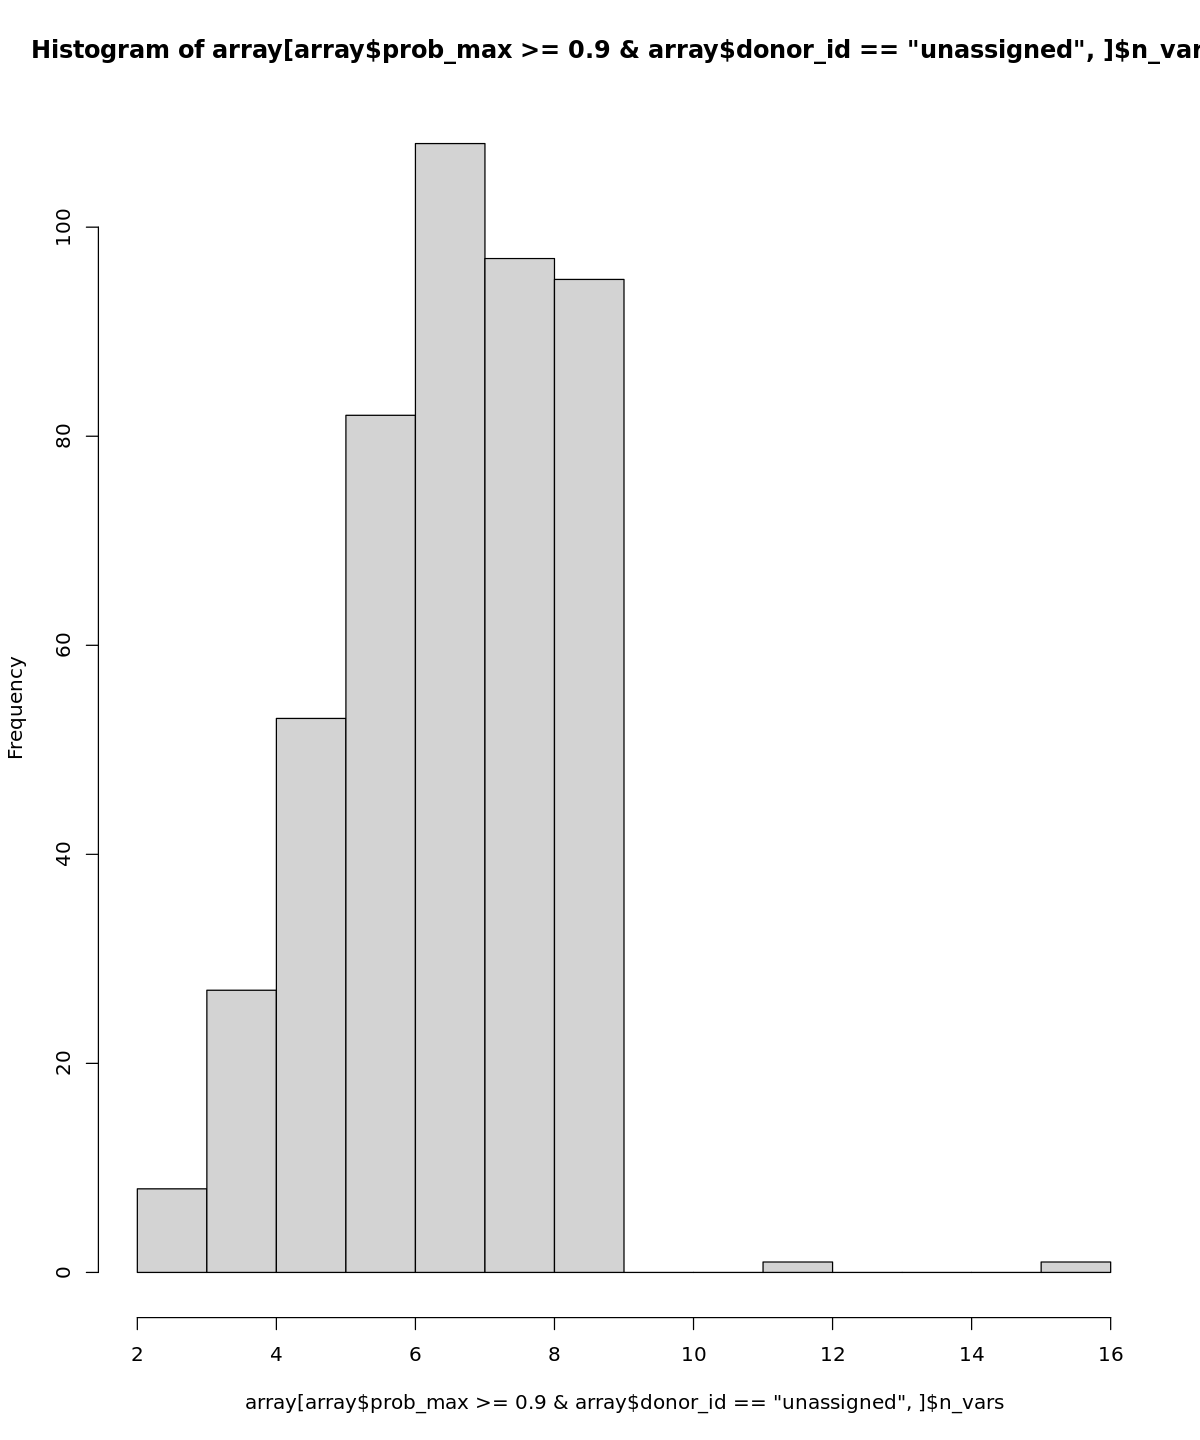

In [106]:
hist(array[array$prob_max >= 0.9 & array$donor_id == 'unassigned',]$n_vars)

In [102]:
head(array)

,cell,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,AAACCCAAGTAGCCAG-1,unassigned,0.437,1.15e-01,11,207762960003_R12C02,"207762960003_R12C02,207762950108_R10C02",2.440
2,AAACCCACATAATGCC-1,unassigned,0.764,9.81e-03,4,207762950108_R10C02,"207762950086_R10C02,207762950108_R10C02",-0.580
3,AAACCCAGTCCGGACT-1,206954930093_R04C02,1.000,2.31e-20,327,206954930093_R04C02,"207762960003_R12C02,206954930093_R04C02",-41.439
4,AAACCCATCAATCCAG-1,207762950055_R12C02,1.000,4.00e-06,44,207762950055_R12C02,"206954930093_R04C02,207762950108_R10C02",-8.653
5,AAACCCATCACTCACC-1,207762950086_R10C02,1.000,1.38e-40,486,207762950086_R10C02,"207762950086_R10C02,207762960003_R12C02",-88.002
6,AAACCCATCGGTGAAG-1,207762950055_R12C02,1.000,2.21e-06,21,207762950055_R12C02,"207762950086_R10C02,207762950055_R12C02",-9.248



FALSE  TRUE 
 1240  3691 

[1] "pCalicoPDsHSrSNiPoold230719B -- Array Assignability: 0.722 -- Imputed Assignability: 0.679"


[1] "pCalicoPDsHSrSNiPoold230719BD -- Array Assignability: 0.909 -- Imputed Assignability: 0.966"


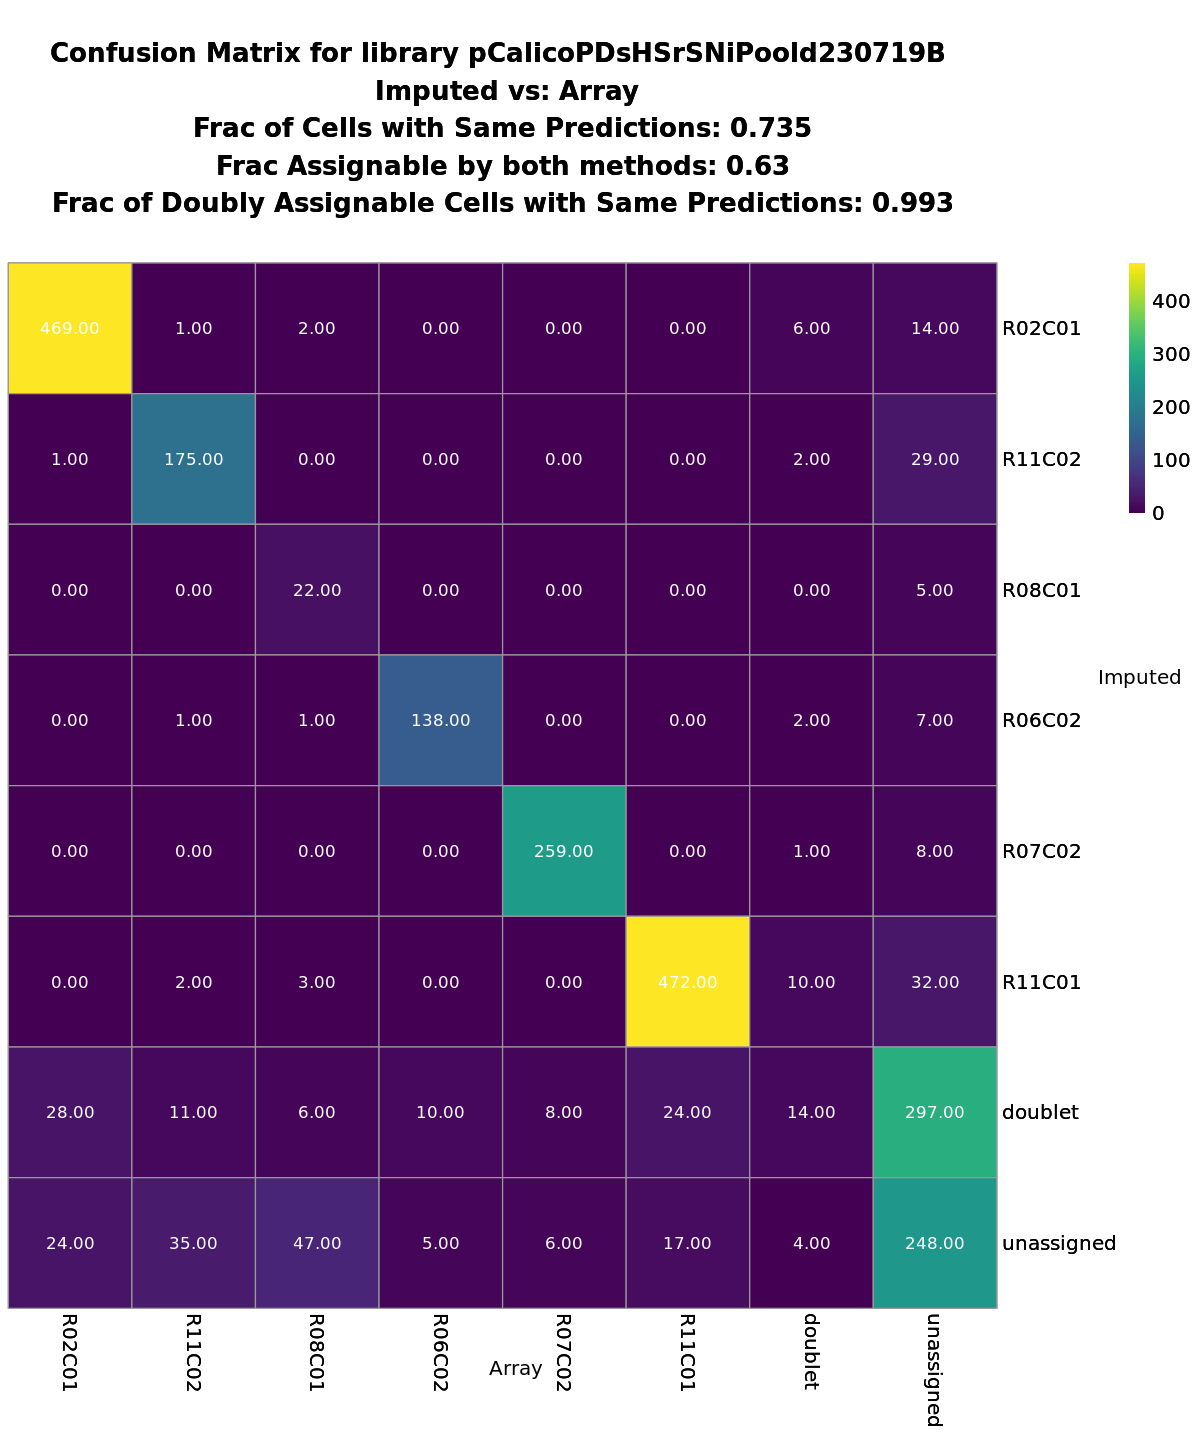

[1] "pCalicoPDsHSrSNiPoold230719C -- Array Assignability: 0.373 -- Imputed Assignability: 0.473"
[1] "pCalicoPDsHSrSNiPoold230719CD -- Array Assignability: 0.665 -- Imputed Assignability: 0.73"


Warning message in levels(reference) != levels(data):
“longer object length is not a multiple of shorter object length”
Warning message in confusionMatrix.default(data = factor(merged_df_doubly_assignable[[col_y]]), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


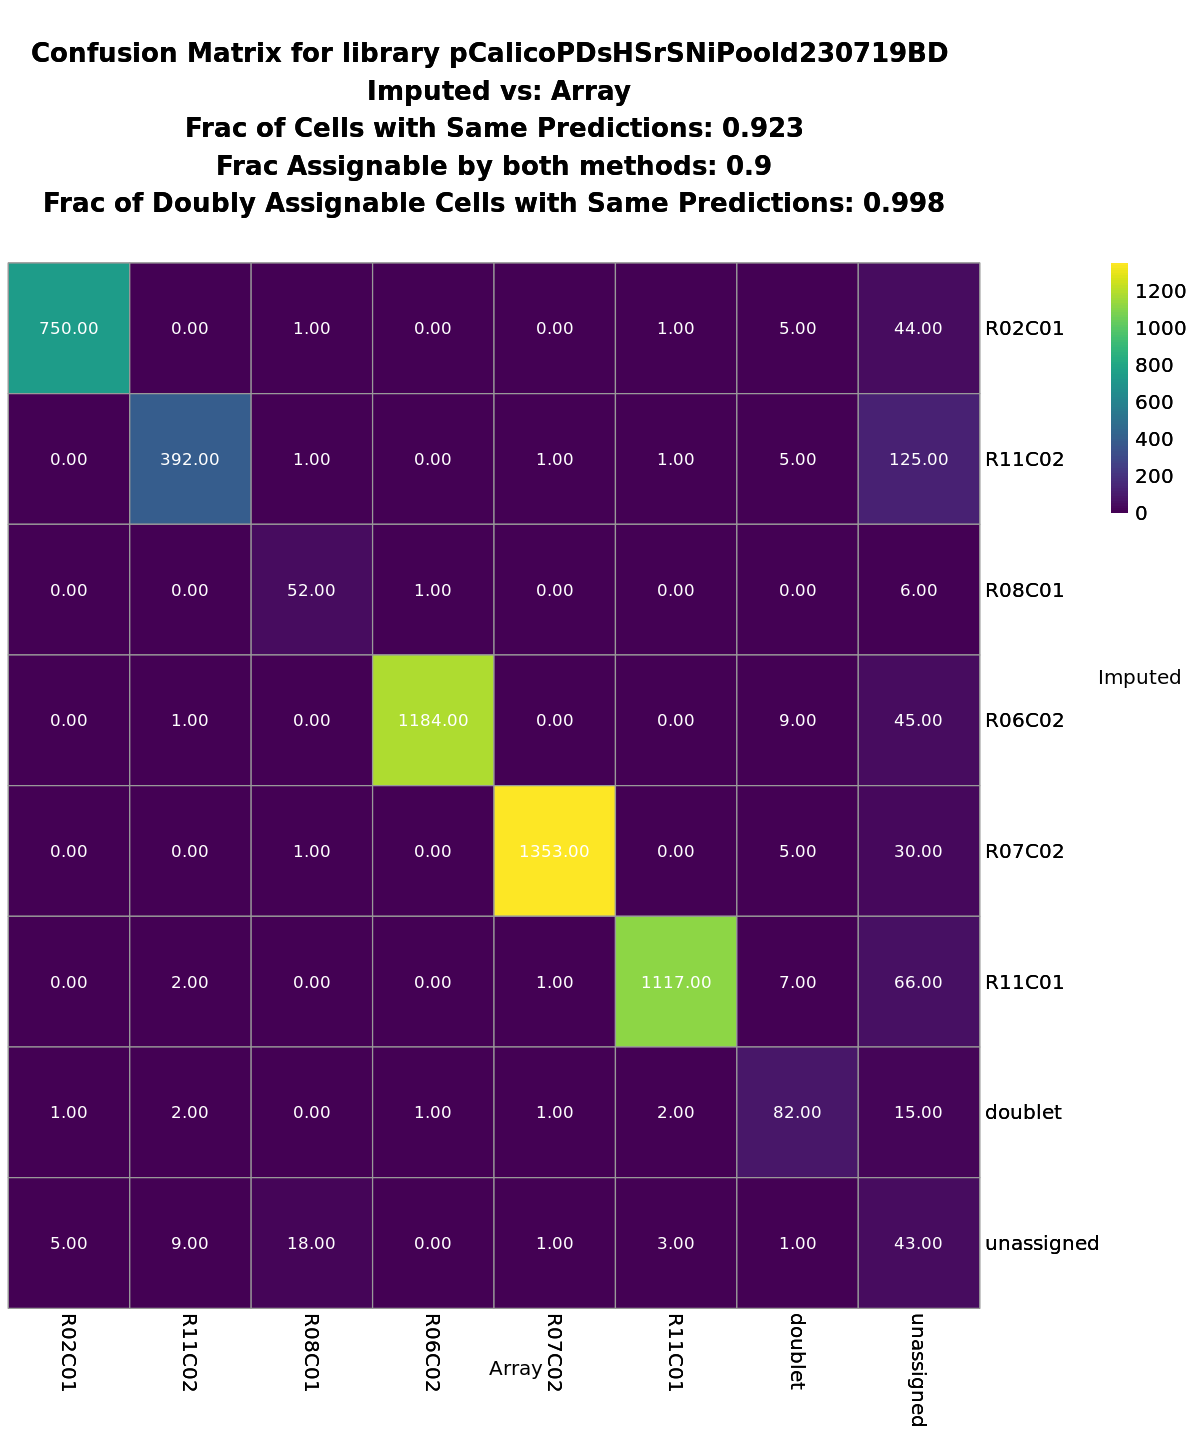

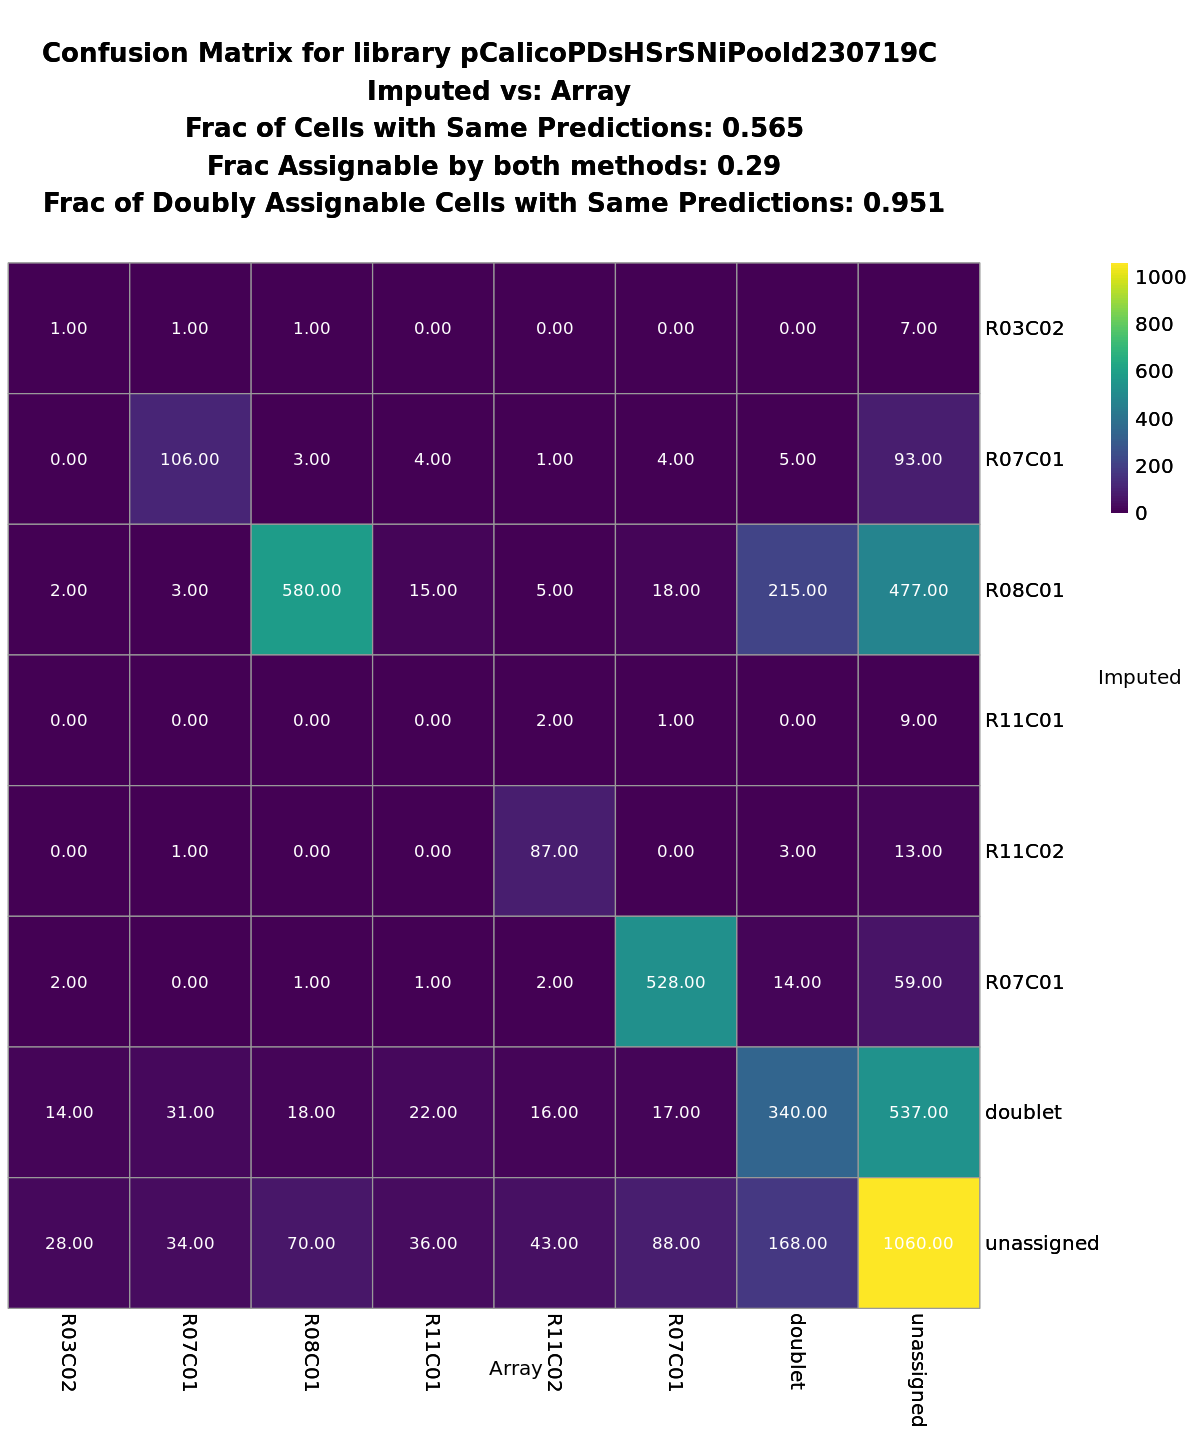

[1] "pCalicoPDsHSrSNiPoold230719D1 -- Array Assignability: 0.355 -- Imputed Assignability: 0.515"


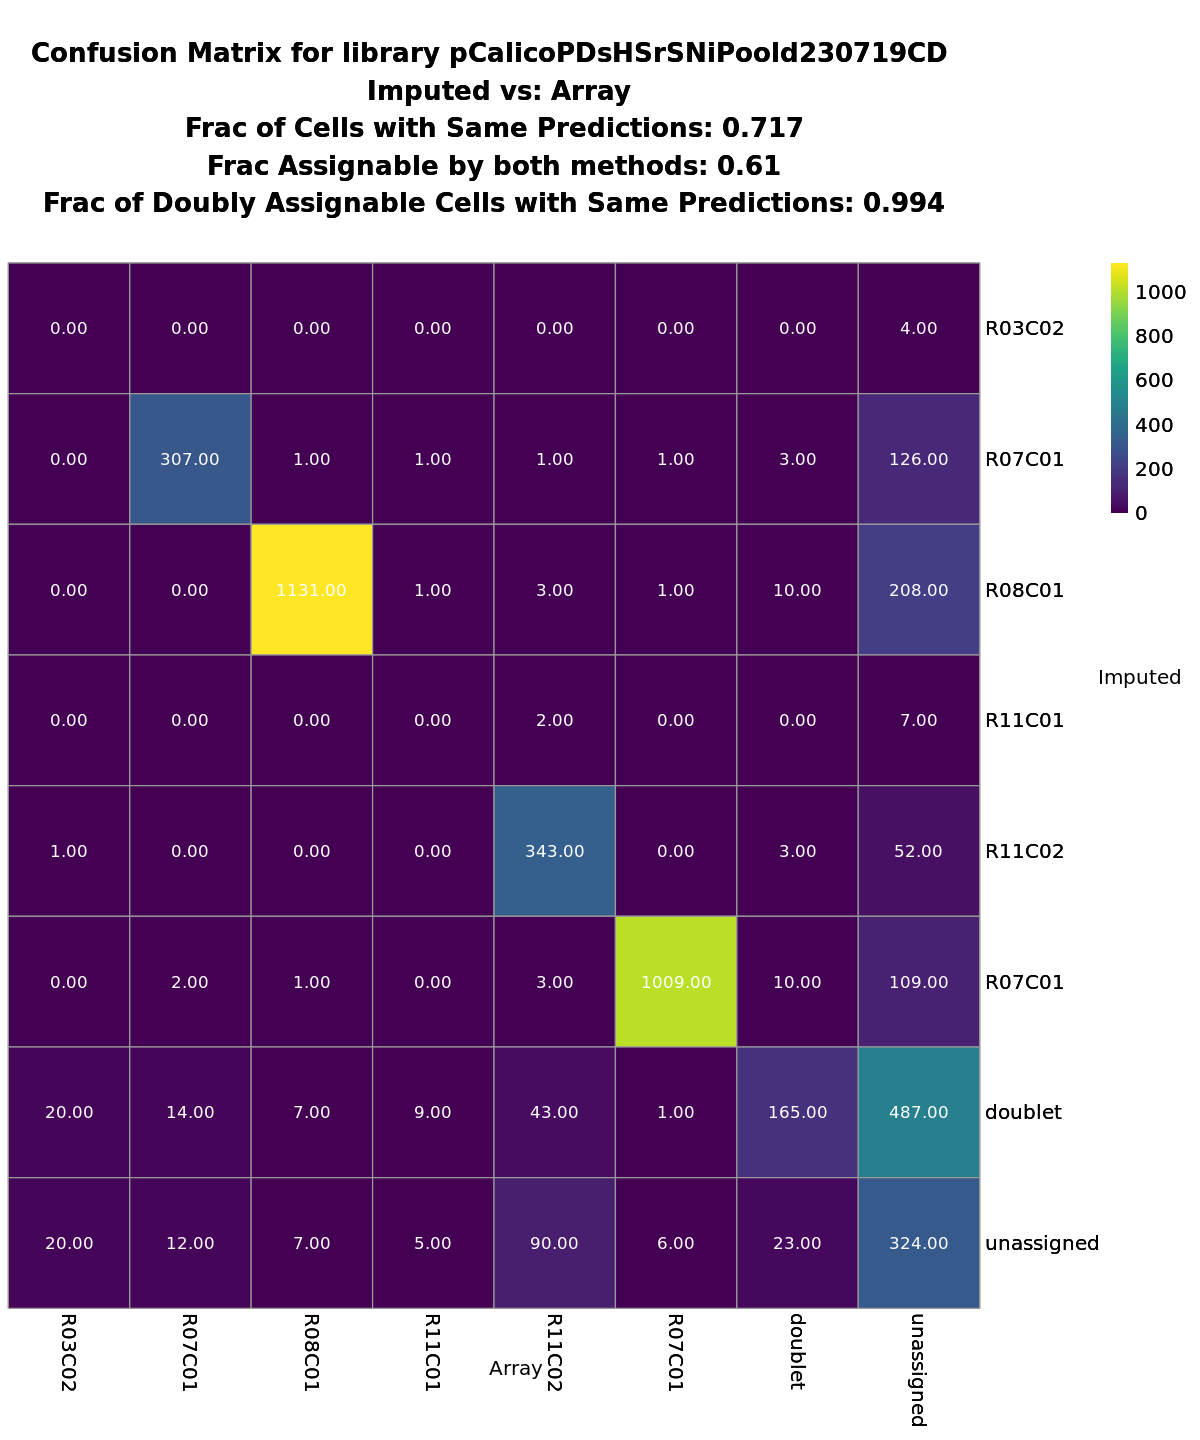

[1] "pCalicoPDsHSrSNiPoold230719D2 -- Array Assignability: 0.724 -- Imputed Assignability: 0.745"


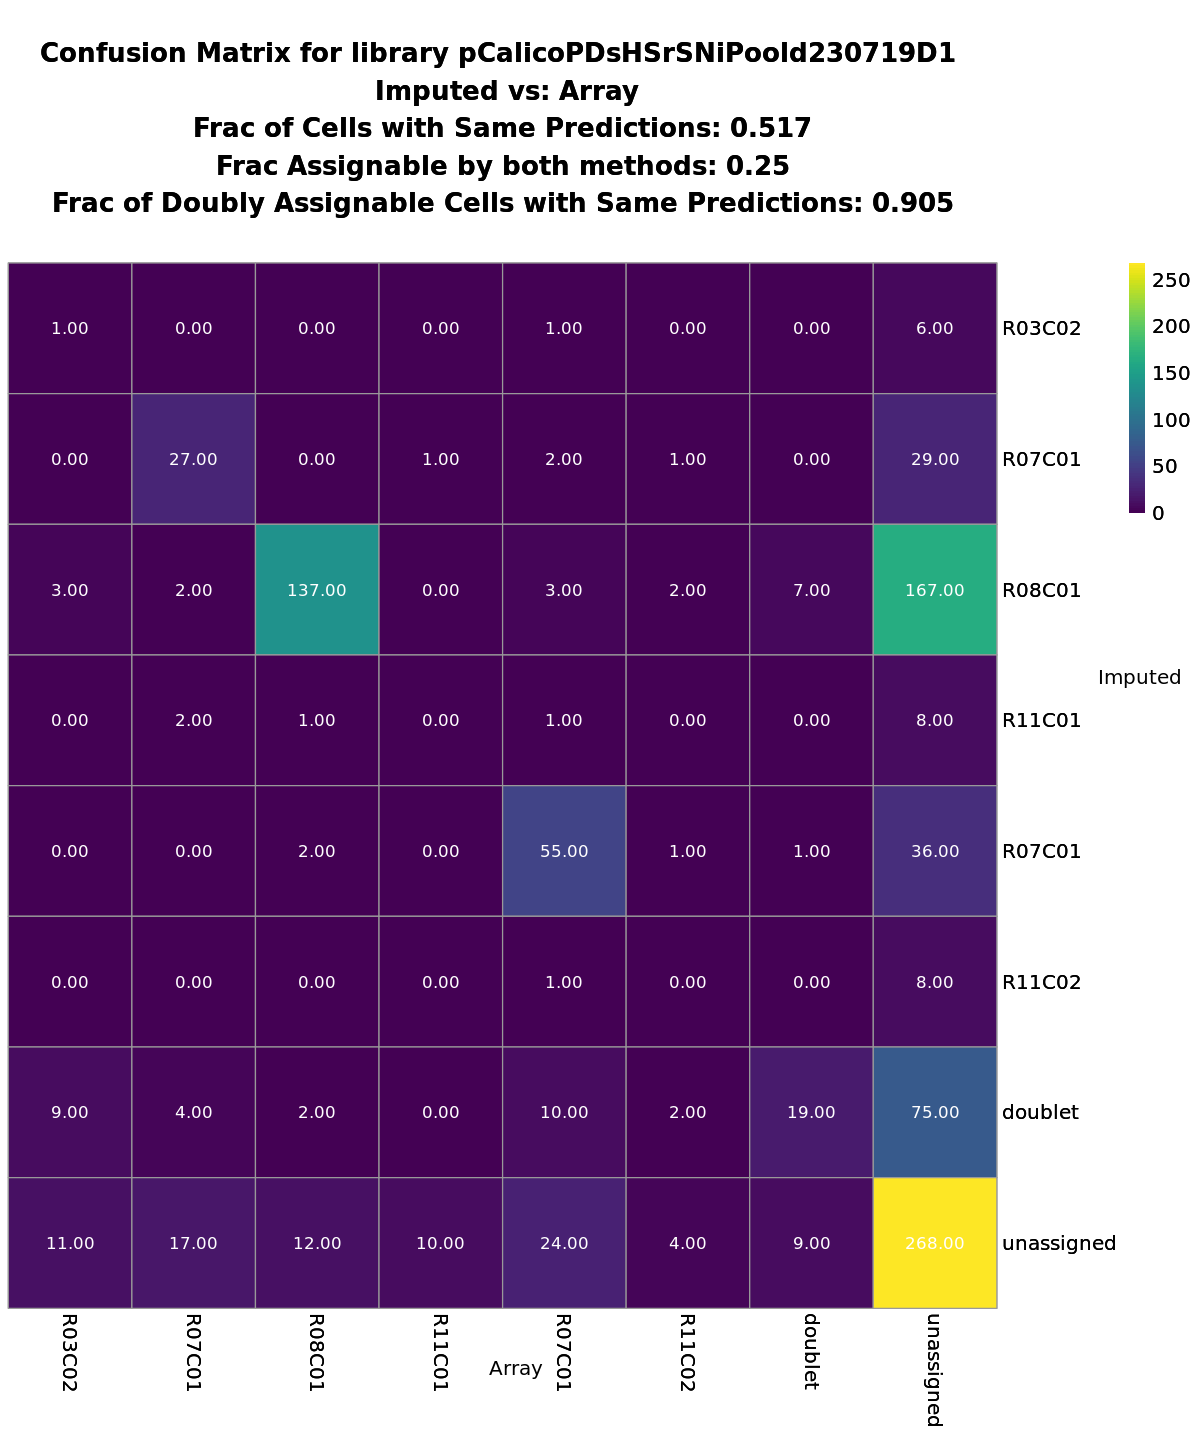

[1] "pCalicoPDsHSrSNC9id230921C9 -- Array Assignability: 0.698 -- Imputed Assignability: 0.91"


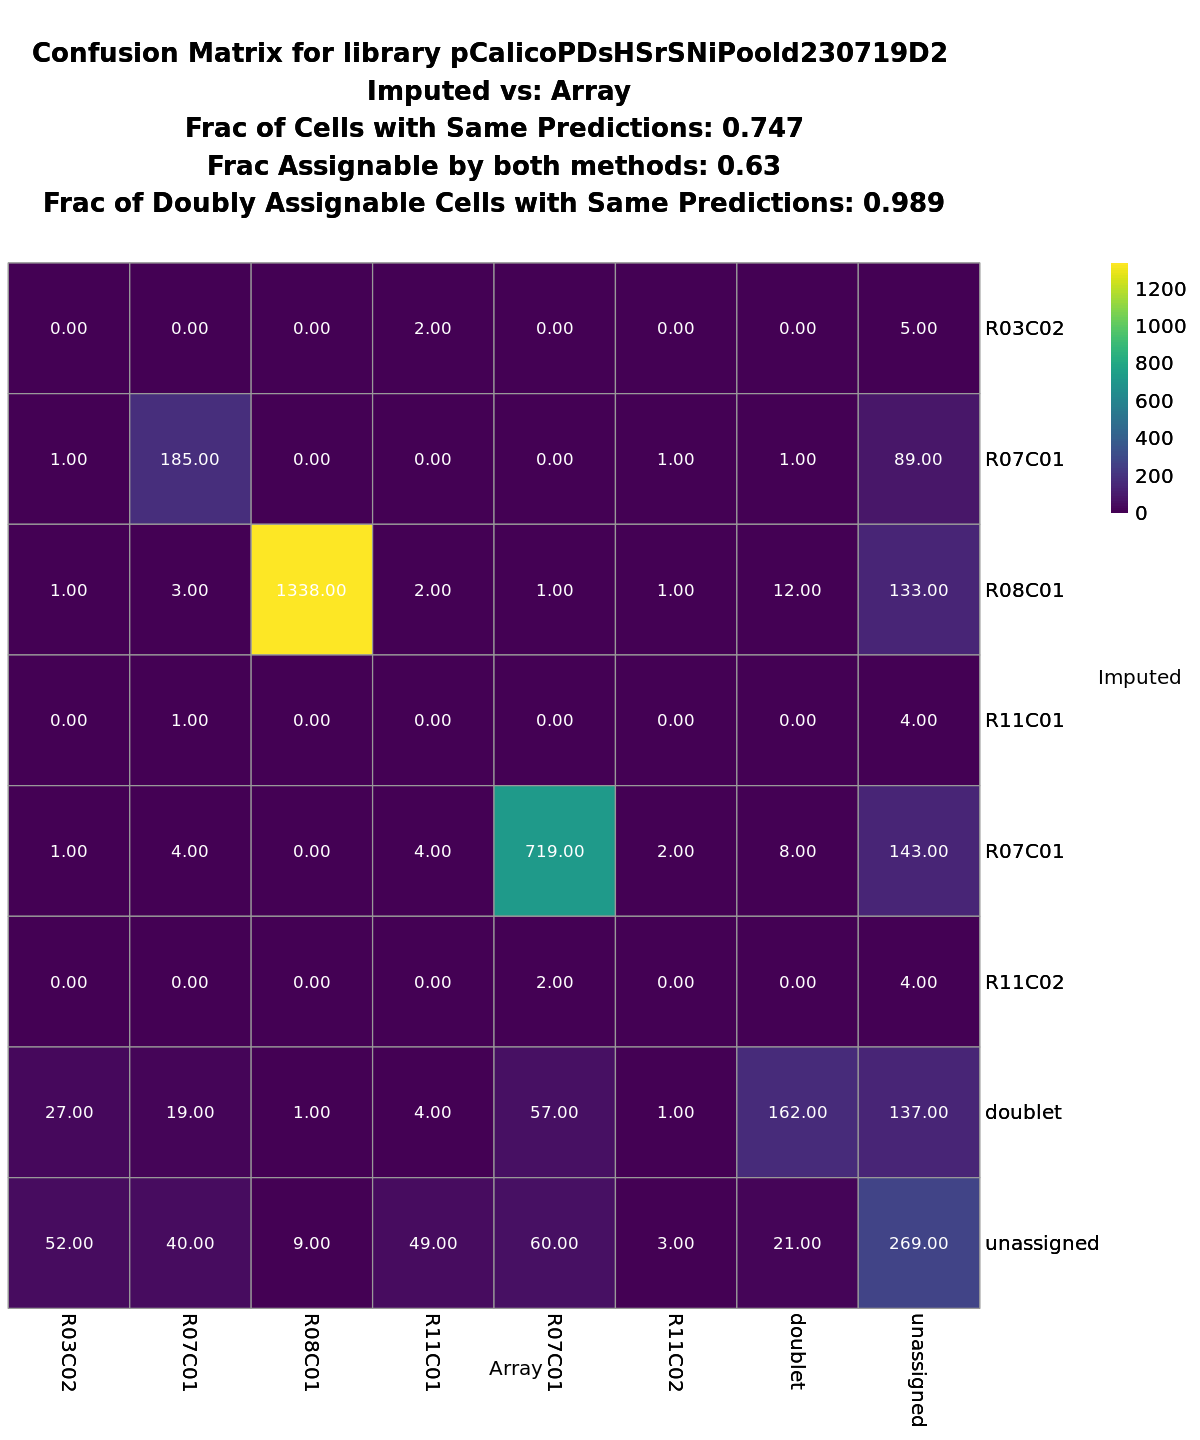

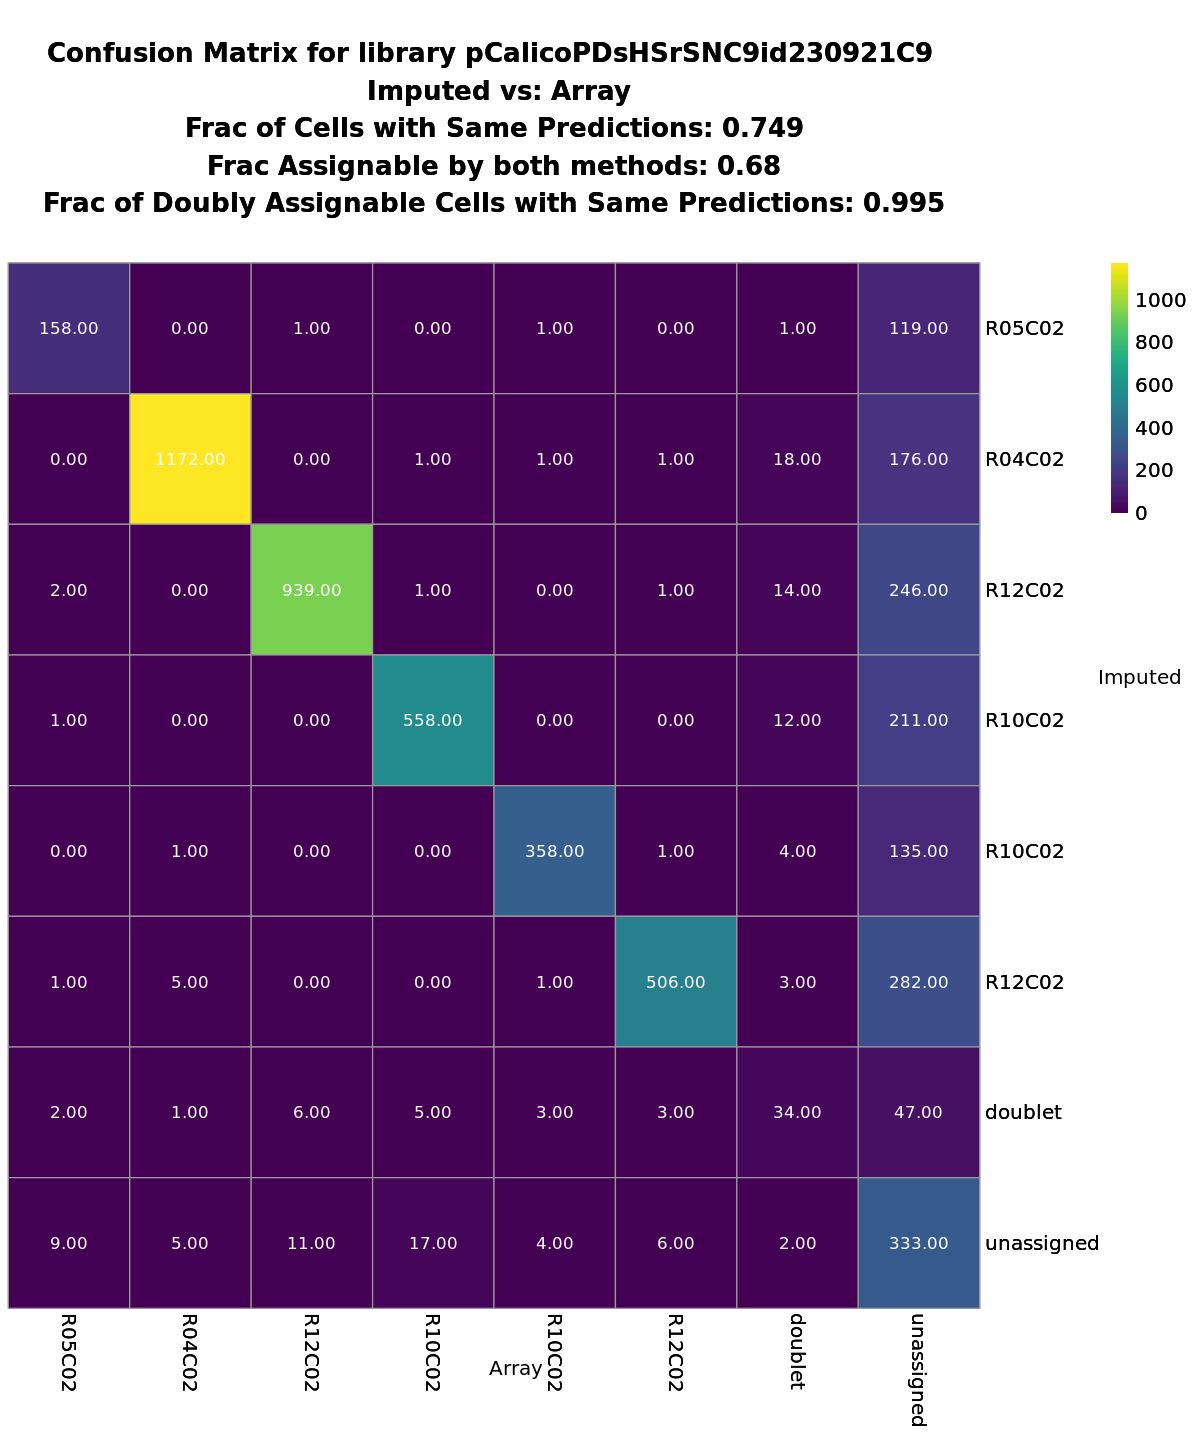

In [85]:
for (name in vireo_dirs){
    array = array_tsvs[[name]]
    imputed = imputed_tsvs[[name]]
    x = round(getFracAssignableVireo(array), 3)
    y = round(getFracAssignableVireo(imputed), 3)
    print(paste(name, '-- Array Assignability:', x, '-- Imputed Assignability:', y))
    merged = merge(array, imputed, by="cell", suffixes=c("_array", "_imputed"))
    getAndPlotConfusionMatrix(merged, name, 
        col_x = "donor_id_array", col_y = "donor_id_imputed", 
        xlab="Array", ylab="Imputed")
    
}